<a href="https://colab.research.google.com/github/catastropiyush/EquiP/blob/main/EquiP_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **EquiP: Machine Learning Model for Predicting Equilibrium Plateau Pressure of Metal Compositions**

The equilibrium plateau pressure (Peq) is a critical thermodynamic parameter, as it defines the conditions under which hydrogen absorption and desorption occur, directly influencing operating conditions of the system. However, experimentally evaluating every possible alloying combination is impractical due to the combinatorial explosion of candidate systems. Particularly, determining Van’t Hoff plots (P eq vs. 1/T) typically requires multiple pressure-temperature measurements.

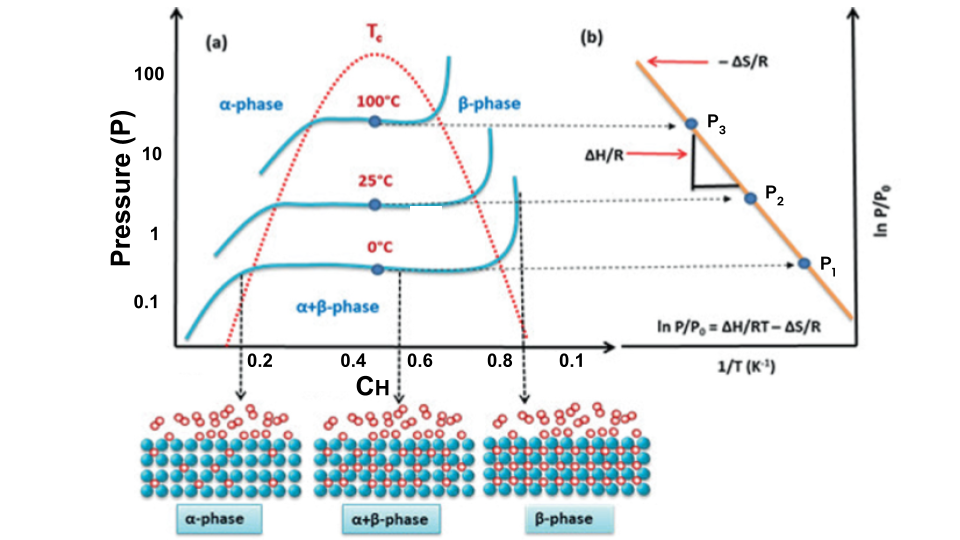

We present EquiP, an ML model trained to predict the equilibrium plateau pressure of metal compositions as a function of temperature. Through EquiP, we have also demonstrated how the incorporation of domain-informed features such as, operating conditions, hydride characteristics, and XRD information brings model predictability closer to experimental results, even with limited data. For example, including temperature as feature not only enhances model
accuracy but also enables determination of Van’t Hoff plots (Peq vs 1/T), facilitating rapid estimation of enthalpy and entropy of hydride formation.

# Step 1: Import Required Libraries
### The notebook starts by importing all the necessary Python libraries for:
### Data handling → pandas, numpy
### Machine learning → scikit-learn"
### Visualization → matplotlib, shap, plotly"


In [2]:
!git clone https://github.com/ashwinidverma/EquiP.git

Cloning into 'EquiP'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 55 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 12.57 MiB | 11.80 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, KFold, ShuffleSplit, GridSearchCV, learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')

# Step 2 : Load and Prepare Dataset
### Load input CSV file (EQUIP_Input_3.csv).
### Select the features and target variable (Ln(P)_Mpa).
### Standardize (normalize) feature values using StandardScaler.
### Split data into training (80%) and test (20%) sets.

In [3]:

data = pd.read_csv('/content/EquiP/Data/EQUIP_Input.csv')
Features = ['Temperature', 'CR', 'Mass', 'FIE', 'BM', 'HF', 'MV', 'M-H_Bond', 'M-H_Eng',
            'formation_H', 'vol_H', 'vol_diff', 'EN.Diff', 'Atomic.Size.Diff', 'dSmix']
scaler = StandardScaler()
data[Features] = scaler.fit_transform(data[Features])
X = data[Features]
y = data["Ln(P)_Mpa"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [4]:
data

no  SrNo PDF_name     Type                            Compostion  \
0      7.0     8   MgSnZn  Lit_PCT                       Mg 95 Sn 3 Zn 2   
1      8.0     9   MgSnZn  Lit_PCT                       Mg 95 Sn 3 Zn 2   
2      9.0    10   MgSnZn  Lit_PCT                       Mg 95 Sn 3 Zn 2   
3     10.0    39       17      PCI                             Mg-0.05In   
4     11.0    40       17      PCI                             Mg-0.05In   
..     ...   ...      ...      ...                                   ...   
288  217.0   393      244      PCT  (TiZr 0.1 ) 1.1 Cr 1.5 Fe 0.2 Mn 0.3   
289  218.0   394      244      PCT  (TiZr 0.1 ) 1.1 Cr 1.5 Fe 0.2 Mn 0.3   
290  187.0   352      182      PCT                              TiZrNbTa   
291  188.0   353      182      PCT                              TiZrNbTa   
292  189.0   354      182      PCT                              TiZrNbTa   

         Class               composition_final  \
0    Mg+TM+Ln+              Mg0.95Sn0.03Zn0.02   
1    Mg+TM+Ln+              Mg0.95Sn0.03Zn0.02   
2    Mg+TM+Ln+              Mg0.95Sn0.03Zn0.02   
3    Mg+TM+Ln+                    In0.05Mg0.95   
4    Mg+TM+Ln+                    In0.05Mg0.95   
..         ...                             ...   
288         TM  Cr0.47Fe0.06Mn0.09Ti0.34Zr0.03   
289         TM  Cr0.47Fe0.06Mn0.09Ti0.34Zr0.03   
290         TM        Nb0.25Ta0.25Ti0.25Zr0.25   
291         TM        Nb0.25Ta0.25Ti0.25Zr0.25   
292         TM        Nb0.25Ta0.25Ti0.25Zr0.25   

                            Element                  Fraction  \
0                   Mg    Sn   Zn              0.95 0.03 0.02   
1                   Mg    Sn   Zn              0.95 0.03 0.02   
2                   Mg    Sn   Zn              0.95 0.03 0.02   
3                           Mg   In                 0.95 0.05   
4                           Mg   In                 0.95 0.05   
..                              ...                       ...   
288  Ti Zr        Cr    Fe    Mn     0.34 0.03 0.47 0.06 0.09   
289     Ti Zr        Cr    Fe    Mn  0.34 0.03 0.47 0.06 0.09   
290                     Ti Zr Nb Ta       0.25 0.25 0.25 0.25   
291                     Ti Zr Nb Ta       0.25 0.25 0.25 0.25   
292                     Ti Zr Nb Ta       0.25 0.25 0.25 0.25   

                         Frac  ...  en_at_H  formation_M en_at_M     vol_H  \
0              0.95 0.03 0.02  ...  -3.0775       0.0107 -1.6548  0.996448   
1              0.95 0.03 0.02  ...  -3.0775       0.0107 -1.6548  0.996448   
2              0.95 0.03 0.02  ...  -3.0775       0.0107 -1.6548  0.996448   
3                   0.95 0.05  ...  -3.0700       0.0110 -1.6465  0.809785   
4                   0.95 0.05  ...  -3.0700       0.0110 -1.6465  0.809785   
..                        ...  ...      ...          ...     ...       ...   
288  0.34 0.03 0.47 0.06 0.09  ...  -6.2698       0.0000 -8.8962  0.120542   
289  0.34 0.03 0.47 0.06 0.09  ...  -6.2698       0.0000 -8.8962  0.120542   
290       0.25 0.25 0.25 0.25  ...  -6.7700       0.0000 -9.6000 -0.375196   
291       0.25 0.25 0.25 0.25  ...  -6.7700       0.0000 -9.6000 -0.375196   
292       0.25 0.25 0.25 0.25  ...  -6.7700       0.0000 -9.6000 -0.375196   

       vol_M  vol_diff   EN.Diff  M-H.EN.Diff  Atomic.Size.Diff     dSmix  
0    44.7960  0.592396 -0.561847      -0.8637         -1.392488 -1.562169  
1    44.7960  0.592396 -0.561847      -0.8637         -1.392488 -1.562169  
2    44.7960  0.592396 -0.561847      -0.8637         -1.392488 -1.562169  
3    43.8840  0.595359 -0.730777      -0.8665         -1.531292 -1.653565  
4    43.8840  0.595359 -0.730777      -0.8665         -1.531292 -1.653565  
..       ...       ...       ...          ...               ...       ...  
288  61.5001 -0.295827 -0.837470      -0.5850         -0.211707  1.100957  
289  61.5001 -0.295827 -0.837470      -0.5850         -0.211707  1.100957  
290  29.5075  0.497598 -0.750535      -0.7075         -0.808752  1.573458  
291  29.5075  0.

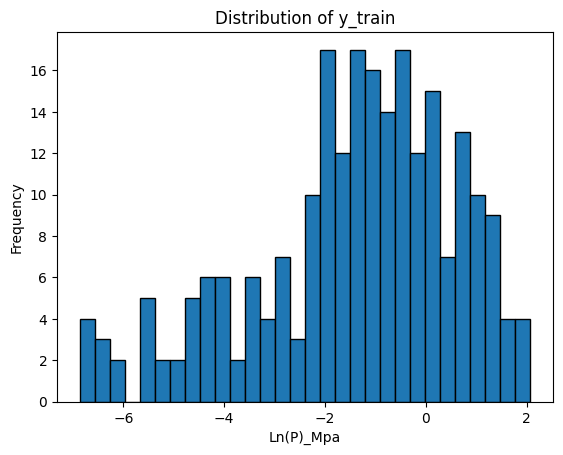

In [5]:
import matplotlib.pyplot as plt

plt.hist(y_train, bins=30, edgecolor='black')
plt.title('Distribution of y_train')
plt.xlabel('Ln(P)_Mpa')
plt.ylabel('Frequency')
plt.show()

In [ ]:
display(X_train.describe())

In [ ]:
# Dataset Overview
# Total points (unique composition–temperature pairs)
# Number of unique compositions
# This gives an overview of dataset diversity and coverage.
Vant_Hoff_Points = len(data.drop_duplicates(['composition_final', 'Temperature']))
Unique_Compositions = len(data['composition_final'].unique())
total = data.shape[0]
print("No of Van't Hoff Plot data points:", Vant_Hoff_Points, "; No of unique composition:", Unique_Compositions)

No of Van't Hoff Plot data points: 293 ; No of unique composition: 77


# Step 3: Hyperparameter Optimization (Grid Search)
### Perform a GridSearchCV to find the best combination of:
### alpha (regularization strength)
### kernel type (linear, rbf, poly)
### gamma (kernel coefficient)
### The best estimator (model configuration) is printed.

In [ ]:
param_grid = {
    'alpha': [0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1.0, 5],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1.0, 5]
}
grid = GridSearchCV(KernelRidge(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_estimator_)

mae_train = mean_absolute_error(y_train, grid.predict(X_train))
mae_test = mean_absolute_error(y_test, grid.predict(X_test))
score_rr = grid.score(X_test, y_test)

print("MSE_train: %0.2f" % mae_train, "MAE_Test: %0.2f" % mae_test, grid.best_params_)

KernelRidge(alpha=0.001, gamma=0.1, kernel='rbf')
MSE_train: 0.09 MAE_Test: 0.11 {'alpha': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}


# Step 4: Train and Evaluate the Optimized Model
### Train the Kernel Ridge Regression (KRR) model using best hyperparameters.
### MAE (Mean Absolute Error) for train and test data
### R2 Score (model fit accuracy)
### Parity Plot to visualize how well predicted values match experimental ones:
### Blue = training data
### Red = validation data



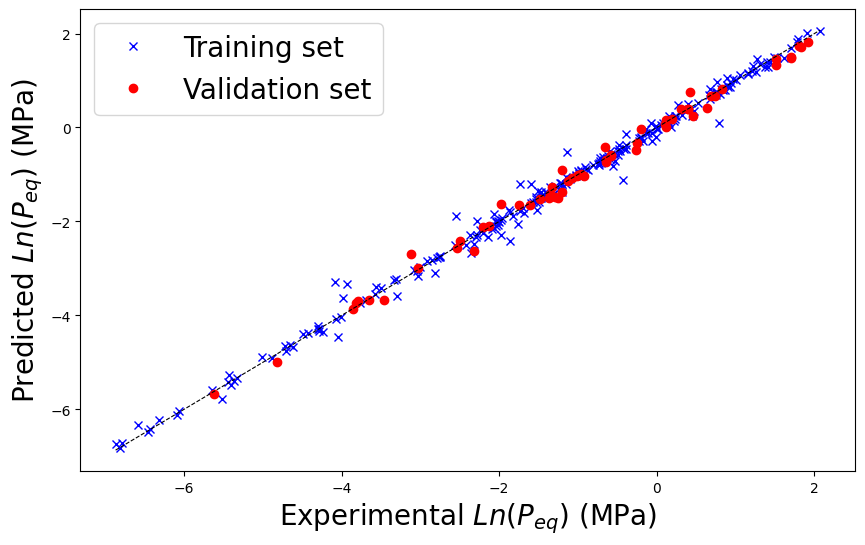

In [ ]:
kr = KernelRidge(kernel='rbf', alpha=0.001, gamma=0.1)
kr.fit(X_train, y_train)
y_train_pred = kr.predict(X_train)
y_pred = kr.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(y_train, y_train_pred, 'xb', label='Training set')
plt.plot(y_test, y_pred, 'or', label='Validation set')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--', lw=0.8, color='black')
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('Experimental $\\it{Ln(P_{eq})}$ (MPa)', fontsize=20)
plt.ylabel('Predicted $\\it{Ln(P_{eq})}$ (MPa)', fontsize=20)
#plt.savefig('OUTPUT/KRR_ML_EXP.png', format='png', dpi=800, bbox_inches='tight')
plt.show()

   k  mean_mae   std_mae  mean_mse  std_mse   mean_r2    std_r2
0  2  0.303845  0.049385  0.275217  0.09887  0.924508  0.035928
1  3  0.202493  0.032725  0.104133  0.03606  0.973137  0.006793


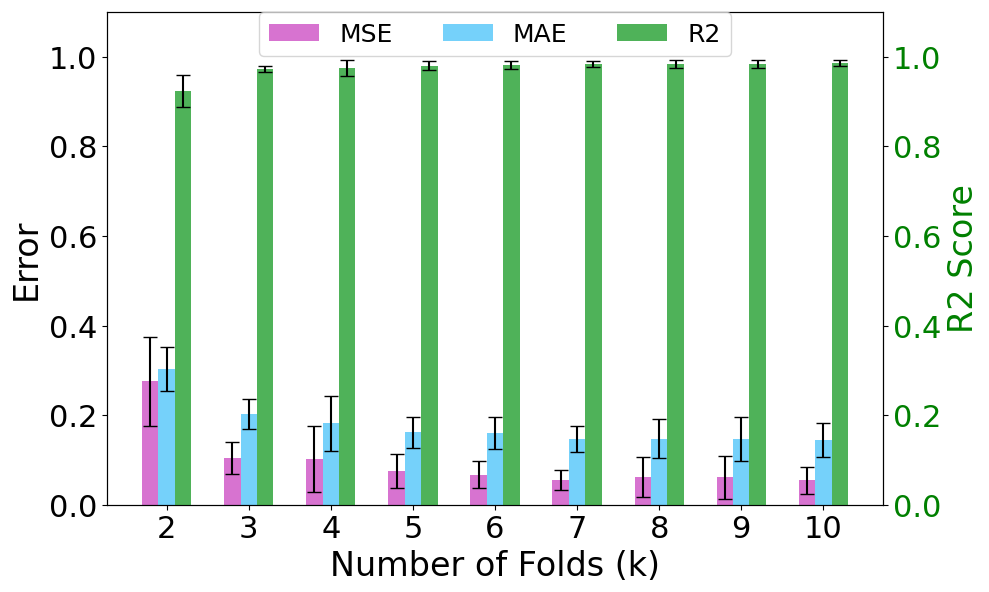

In [ ]:
# Evaluate Model for Different K Values
# Run multiple K-fold validations (for K = 2 → 10)
# to see how error metrics change with the number of folds.
# Calculates and stores:
# Mean and standard deviation of MAE, MSE, R²
# Results are stored in a DataFrame (results_df).
# Define metrics and storage

# Visualize Cross-Validation Metrics
# Create a bar plot showing:
# MAE and MSE (left y-axis)
# R² (right y-axis)
# for each k value.
# This helps compare model stability as the number of folds varies.

scoring = {
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error',
    'r2': 'r2'
}
k_values = np.arange(2,11,1)
results = []

# Iterate over different k values
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Run cross-validation once for all metrics
    cv_results = cross_validate(kr, X, y, cv=kf, scoring=scoring)

    # Compute mean and std for each metric
    mean_mae = -np.mean(cv_results['test_mae'])
    std_mae = np.std(cv_results['test_mae'])
    mean_mse = -np.mean(cv_results['test_mse'])
    std_mse = np.std(cv_results['test_mse'])
    mean_r2 = np.mean(cv_results['test_r2'])
    std_r2 = np.std(cv_results['test_r2'])

    # Store results in a structured format
    results.append({
        'k': k,
        'mean_mae': mean_mae,
        'std_mae': std_mae,
        'mean_mse': mean_mse,
        'std_mse': std_mse,
        'mean_r2': mean_r2,
        'std_r2': std_r2
    })

# Convert to DataFrame for easy plotting and analysis
results_df = pd.DataFrame(results)
print(results_df.head(2))

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.xticks(k_values, k_values, fontsize=22)
# Bar plot with error bars for Mean Absolute Error (MAE)
bar_width = 0.2
ax1.set_ylim(0, 1.1)
k_values_shifted = k_values - bar_width
ax1.bar(k_values_shifted, results_df['mean_mse'], width=bar_width, yerr=results_df['std_mse'], capsize=5, color='#C738BD', alpha=0.7, label='MSE')
ax1.bar(k_values, results_df['mean_mae'], width=bar_width, yerr=results_df['std_mae'], capsize=5, color='#3ABEF9', alpha=0.7, label='MAE')
ax1.set_xlabel('Number of Folds (k)', fontsize=24)
ax1.set_ylabel('Error', fontsize=24)
ax1.tick_params(axis='y', labelsize=22)

ax2 = ax1.twinx()
ax2.set_ylim(0, 1.2)
ax2.bar(k_values + bar_width, results_df['mean_r2'], width=bar_width, yerr=results_df['std_r2'], capsize=5, color='#059212', alpha=0.7, label='R2')
ax2.set_ylabel('R2 Score', color='g', fontsize=24)
ax2.tick_params(axis='y', labelcolor='g', labelsize=22)
plt.ylim(0,1.1)

# Add legend
fig.legend(loc='upper center',shadow=False, ncol=3, fontsize=18)

plt.tight_layout()
#plt.savefig('OUTPUT/KRR_ML_K-fold.png',format='png',dpi=800, bbox_inches='tight')
plt.show()

# ***#Step 5: SHAP (Feature Importance) Analysis***
###Compute SHAP values to explain model predictions
###Generate SHAP summary plots and bar plots
###Rank features by mean absolute SHAP value (importance)
###This provides insight into which physical or chemical descriptors most strongly influence equilibrium pressure



In [ ]:
import shap
# SHAP Explainer
model=KernelRidge(kernel='rbf', alpha = 0.001, gamma = 0.1)
model.fit(X_train, y_train)
explainer = shap.KernelExplainer(model.predict,X_train)
shap_values = explainer(X_test)


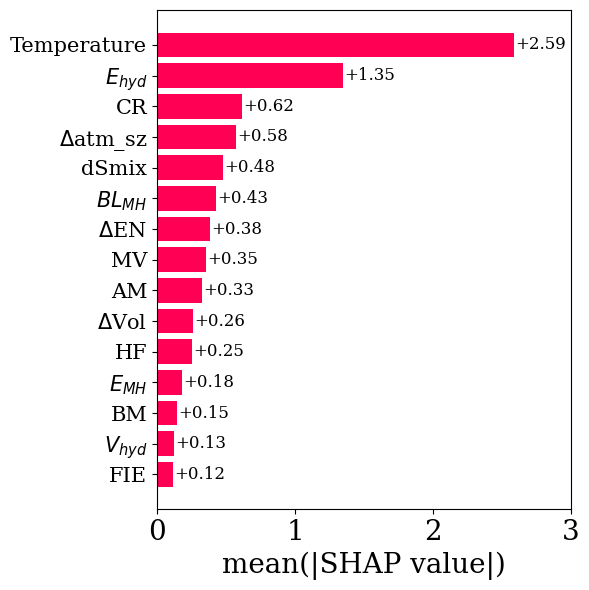

In [ ]:
mean_shap = np.abs(shap_values.values).mean(axis=0)
feature_names = X_test.columns
# Sort by importance
sorted_idx = np.argsort(mean_shap)[::-1]
sorted_means = mean_shap[sorted_idx]
sorted_features = [r'Temperature', r'$E_{hyd}$', r'CR', r'$\Delta$atm_sz', r'dSmix',
            r'$BL_{MH}$', r'$\Delta$EN', r'MV', r'AM', r'$\Delta$Vol', r'HF',
             r'$E_{MH}$', r'BM', r'$V_{hyd}$', r'FIE']
# Bar plot manually (instead of shap.plots.bar)
fig, ax = plt.subplots(figsize=(6, 6))
plt.locator_params(nbins=5)
ax.barh(range(len(sorted_means)), sorted_means, align="center",color= "#ff0055")
ax.set_yticks(range(len(sorted_means)))
ax.set_yticklabels(sorted_features,fontsize=15)
ax.invert_yaxis()  # most important at top
ax.set_xlabel("mean(|SHAP value|)",fontsize=20)
# Add SHAP values at the end of bars
for i, v in enumerate(sorted_means):
    ax.text(v + 0.01, i, f"{ v:+.2f}", va="center", fontsize=12)
plt.xlim(0,3)
plt.xticks(fontsize=20)
plt.tight_layout()

#plt.savefig('OUTPUT/SHAP_FI.png',format='png',dpi=800, bbox_inches='tight')
plt.show()

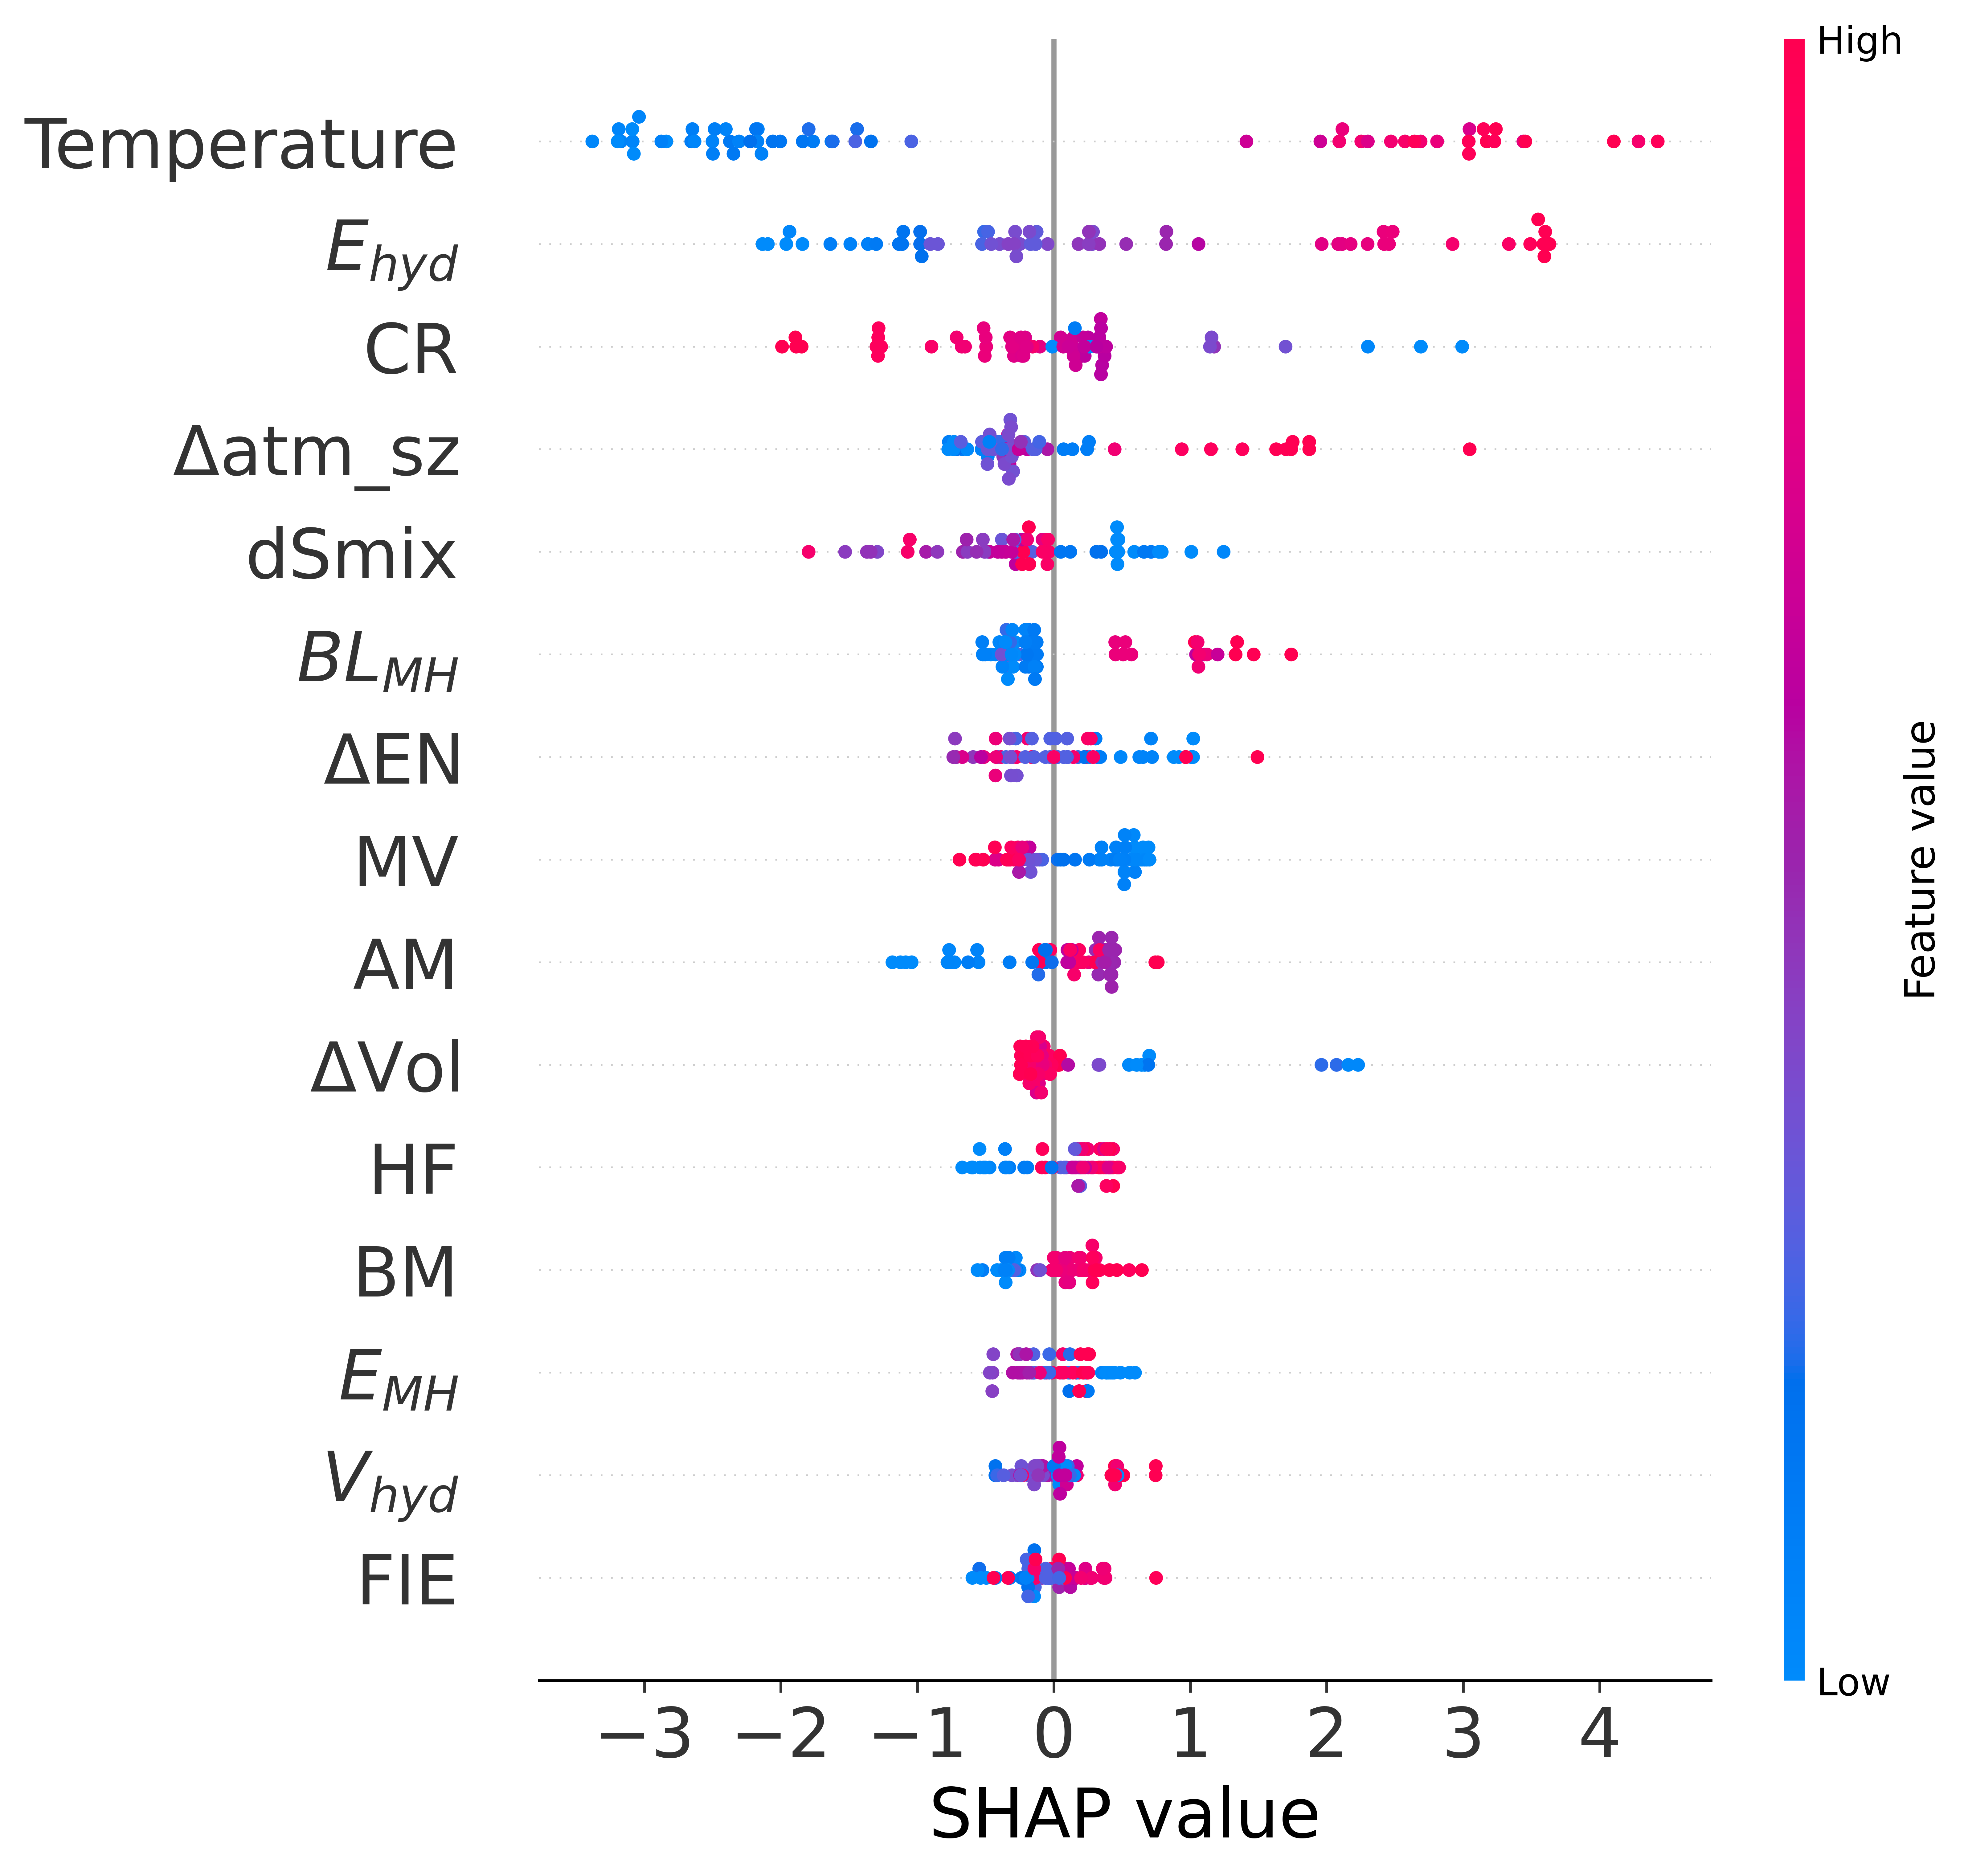

# **#Step 7: Leave-One-Composition-Out (LOCO) Analysis**
### Iteratively removes one composition from training
### train model on n-1 compositions
### Predicts Peq for removed composition using the rest of the data
### Compares predicted vs. experimental P–T relationships
### Estimates ΔH (enthalpy) and ΔS (entropy) via Van’t Hoff fits
### Plots are generated showing both experimental and model-predicted trends for each composition.

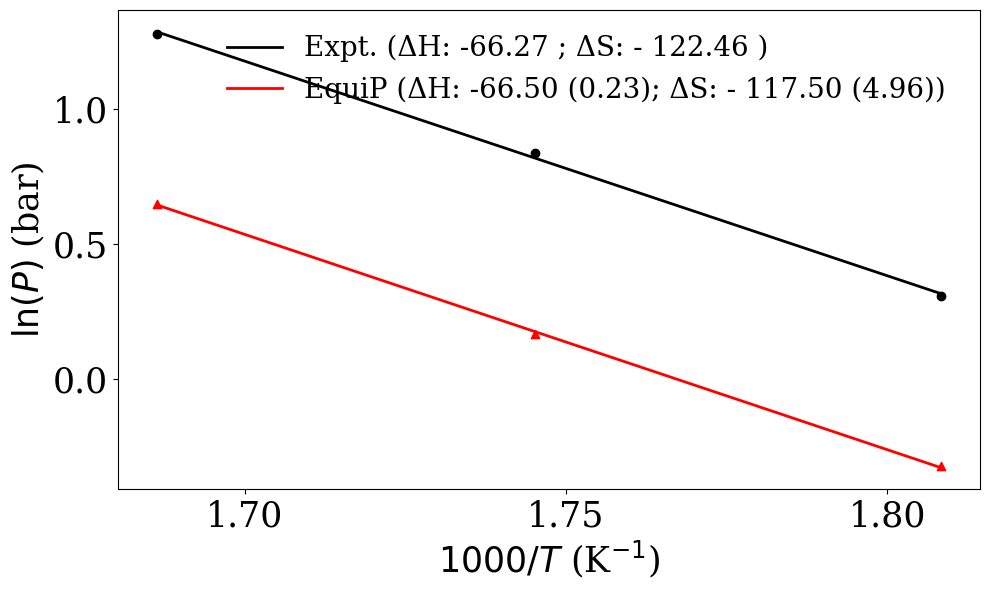

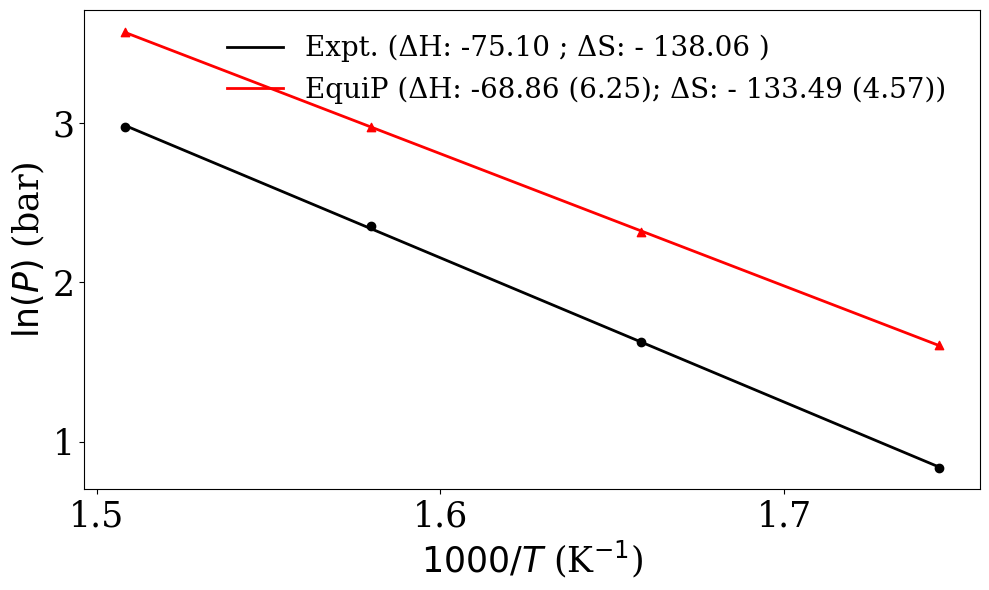

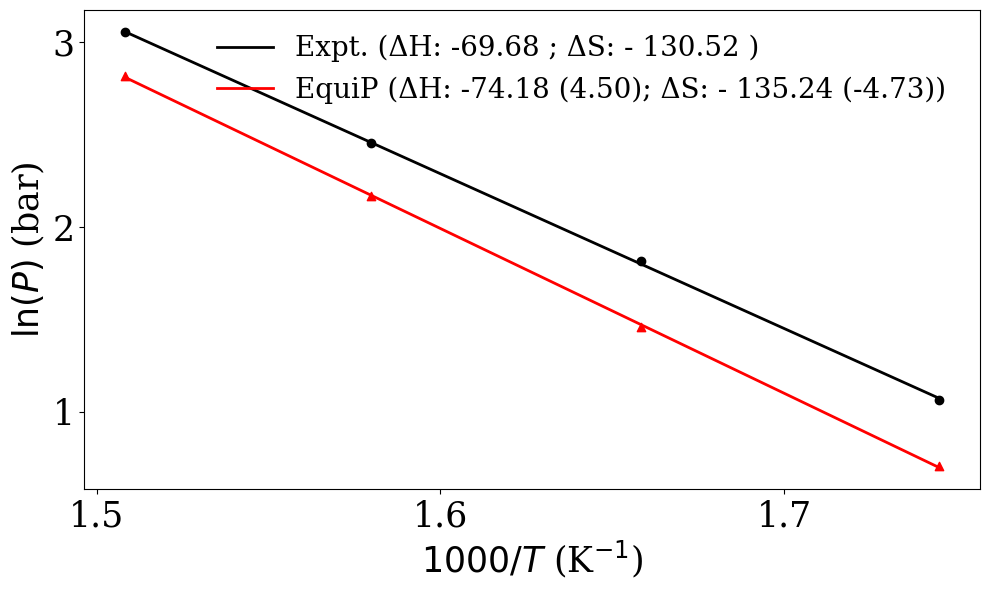

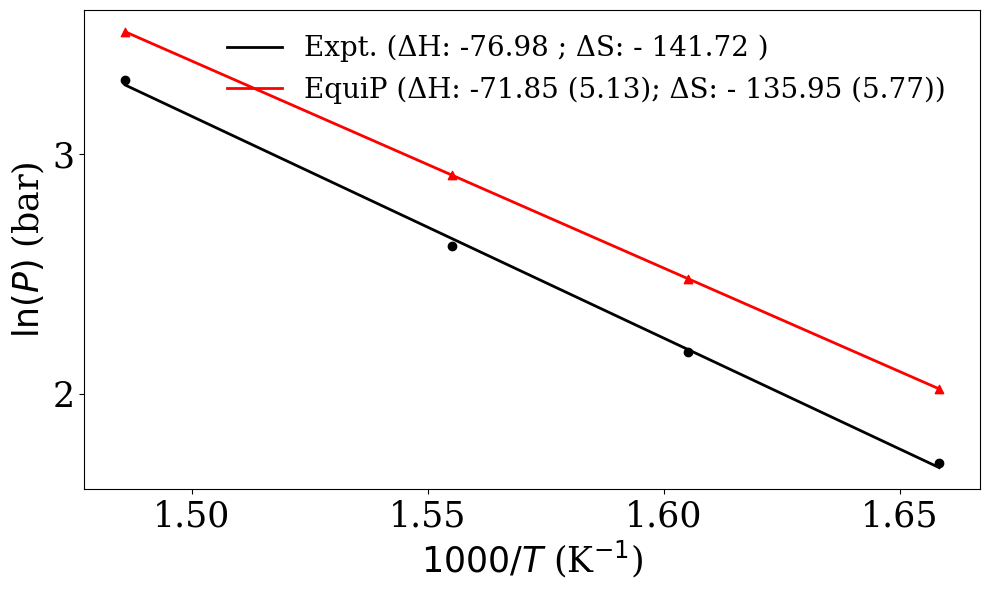

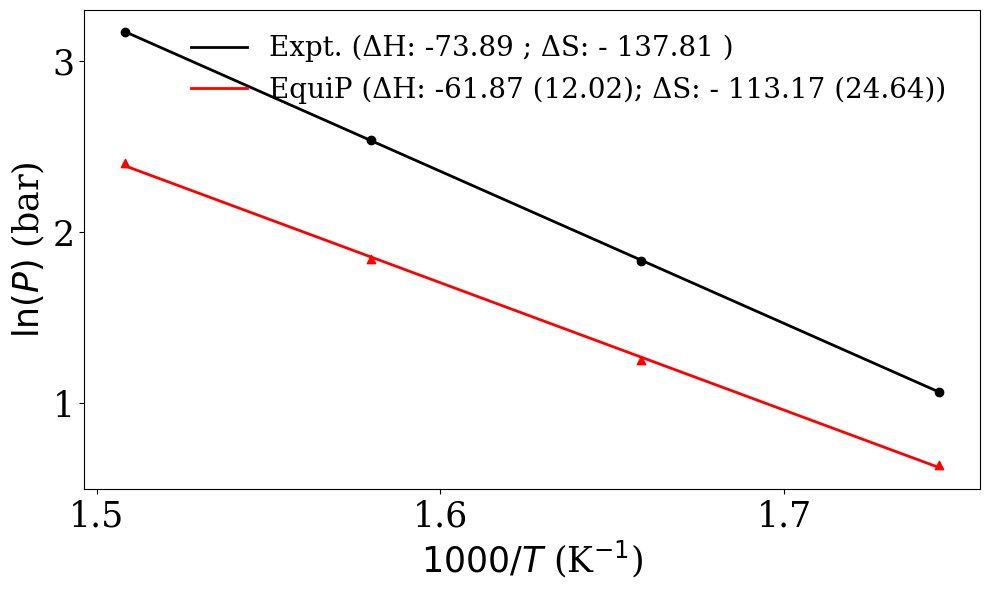

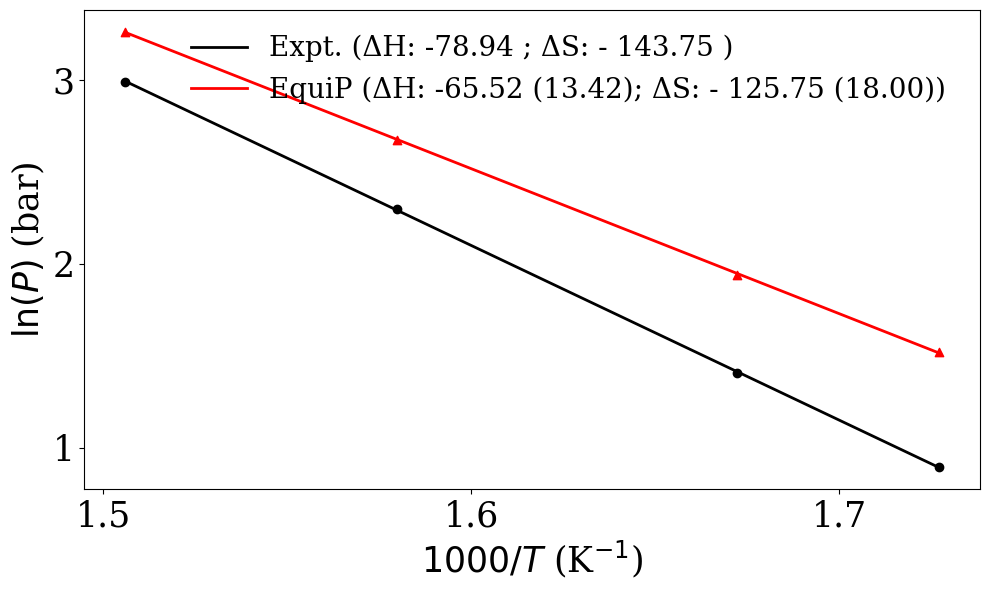

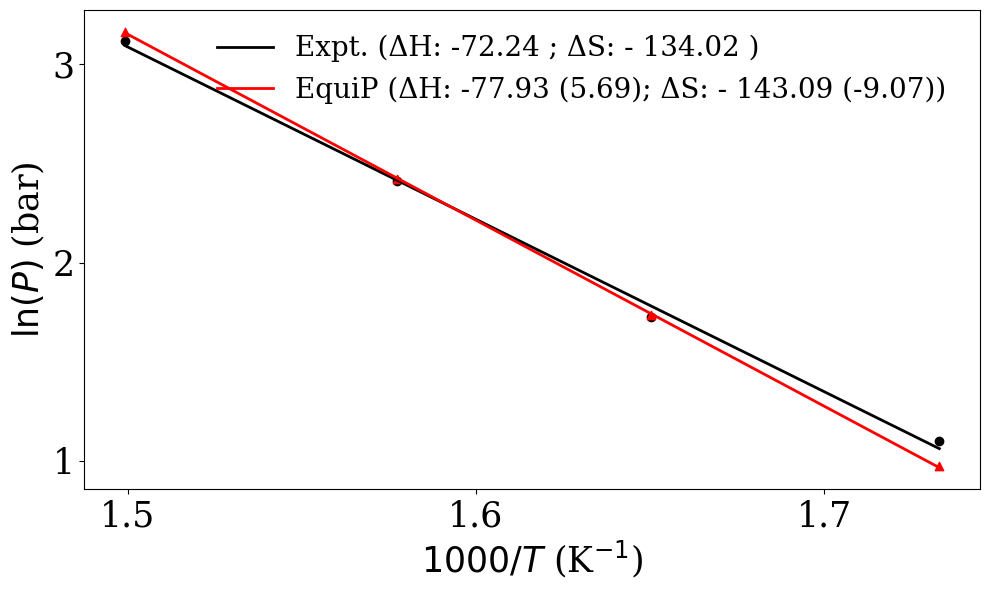

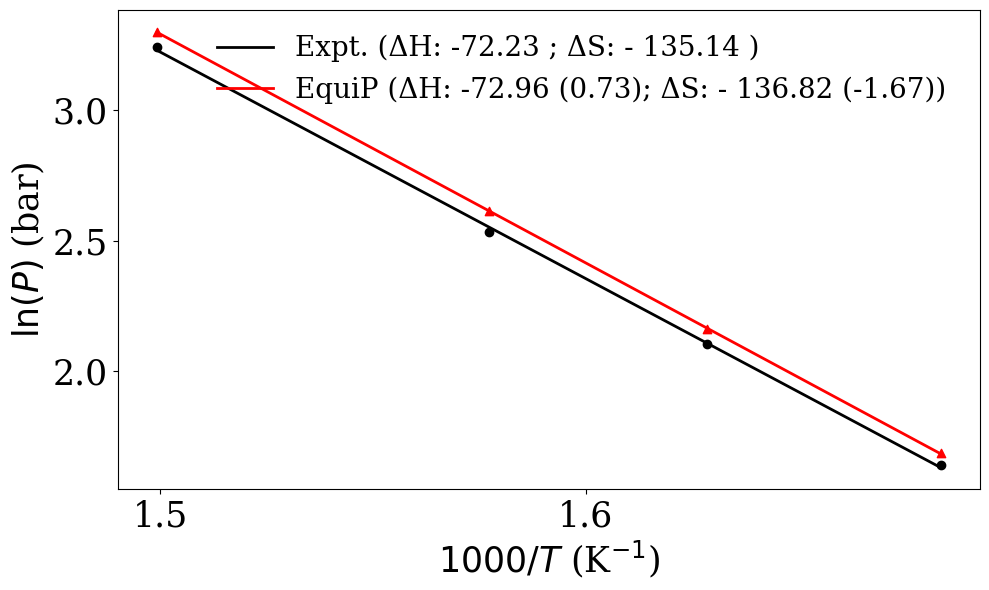

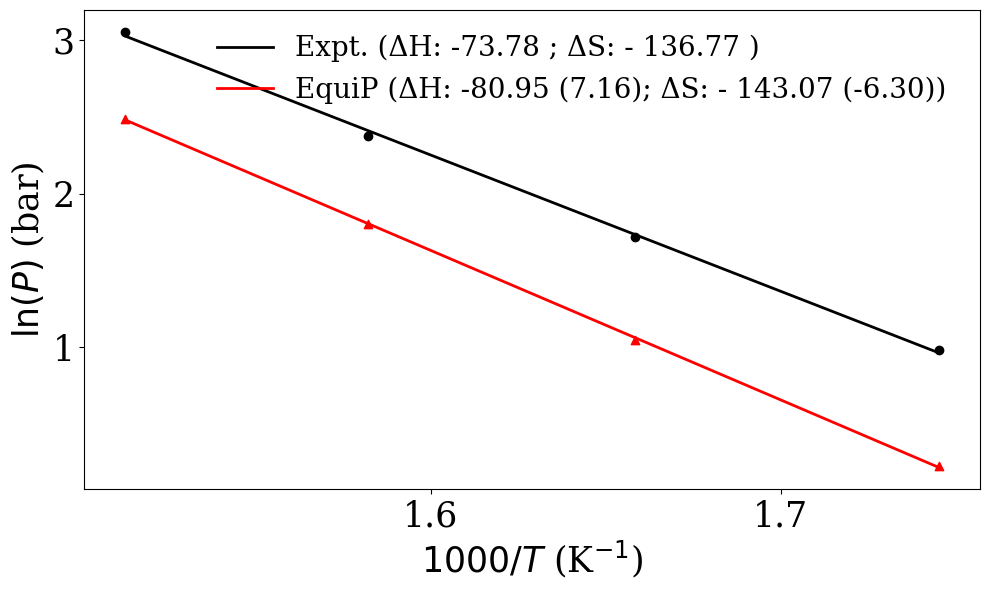

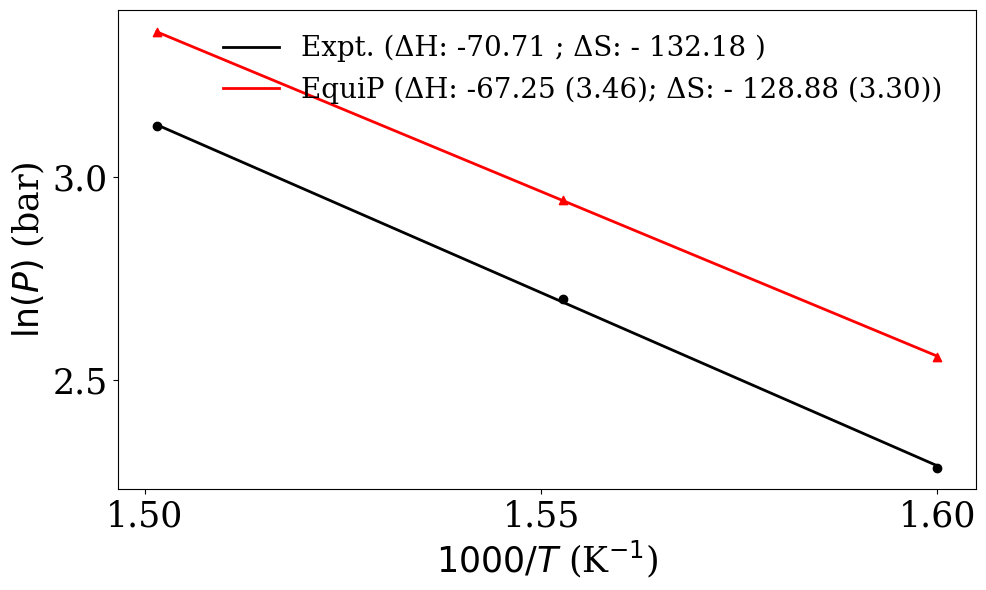

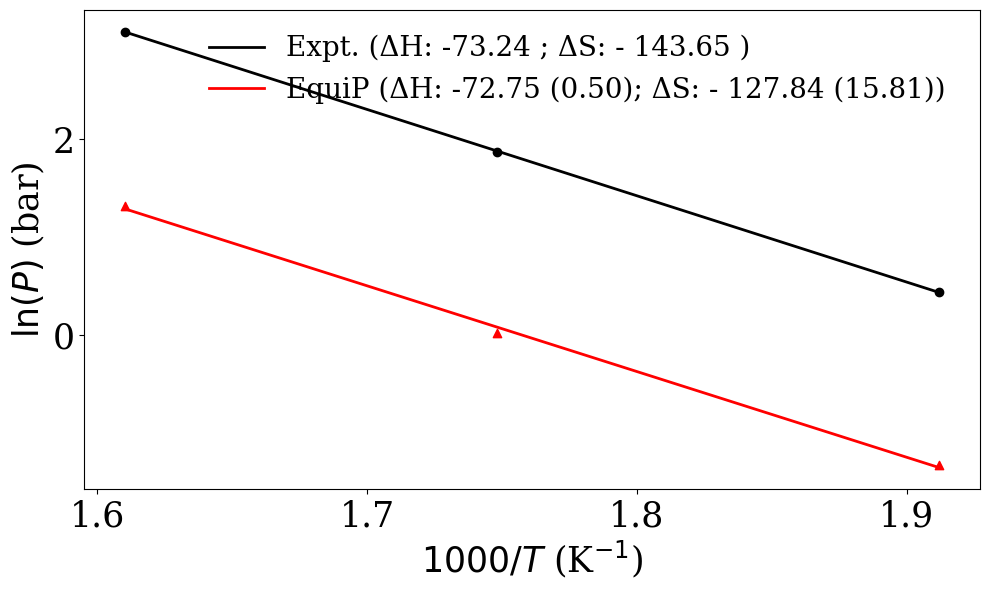

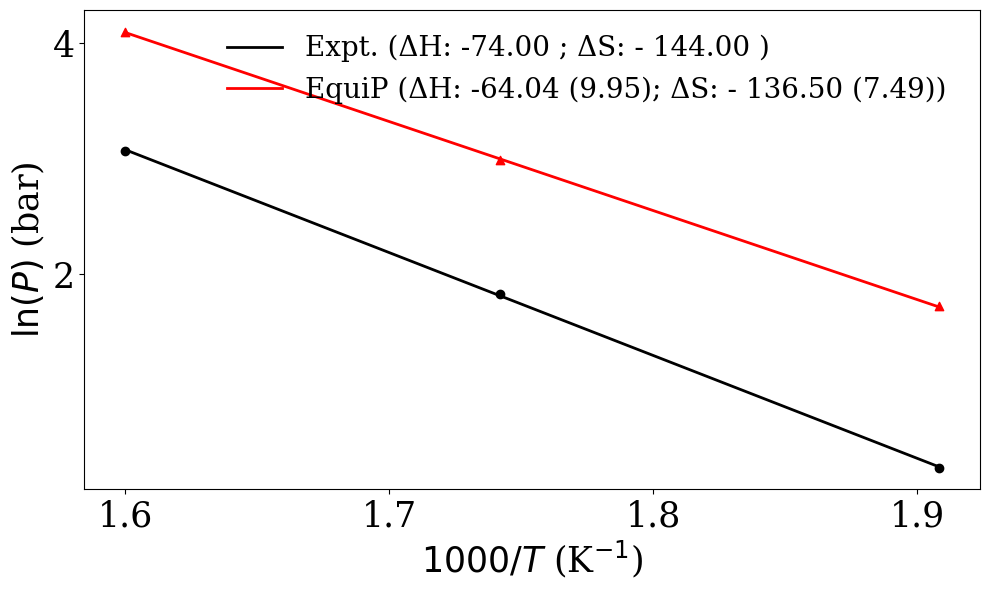

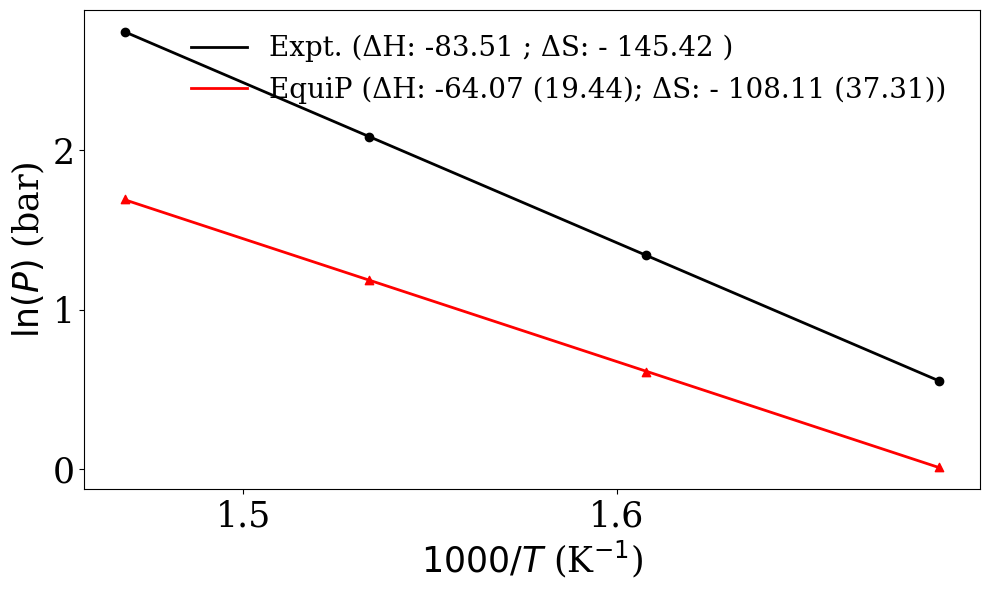

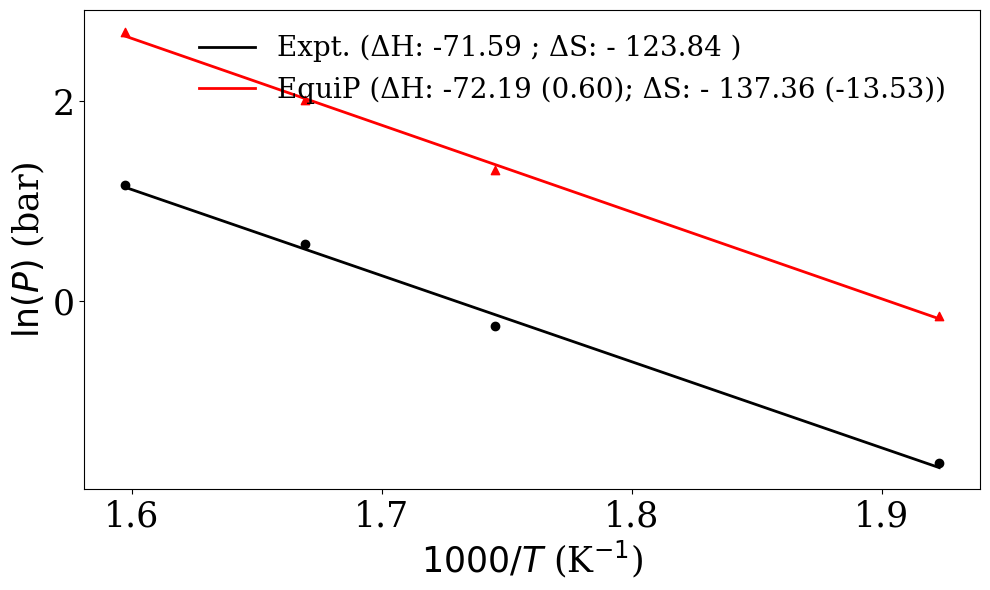

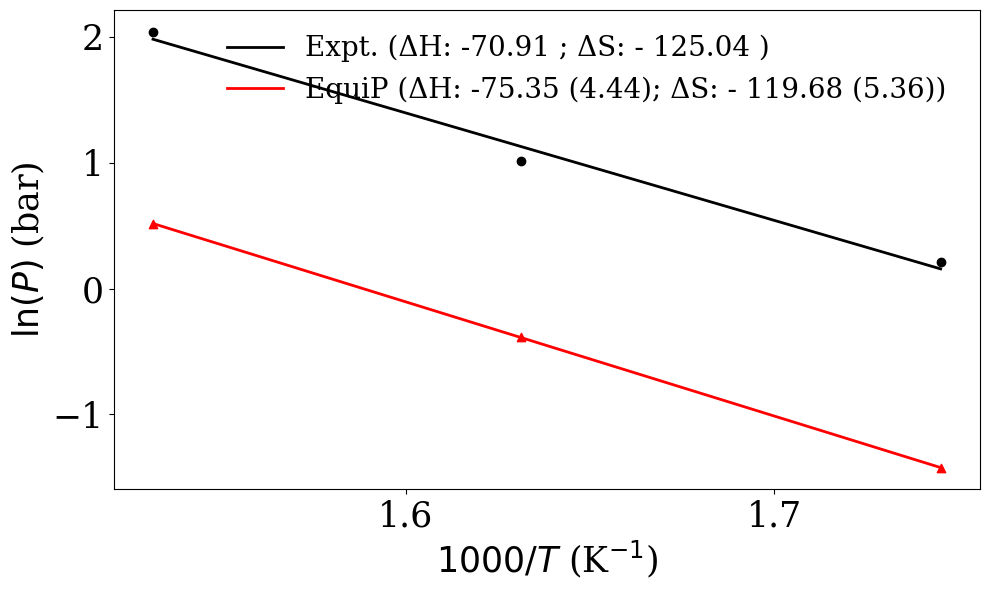

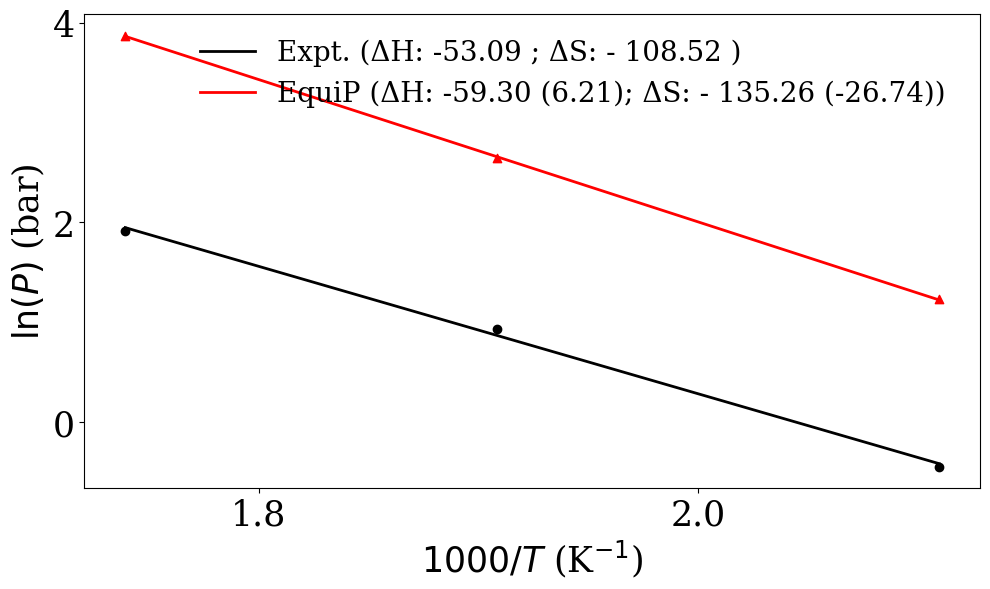

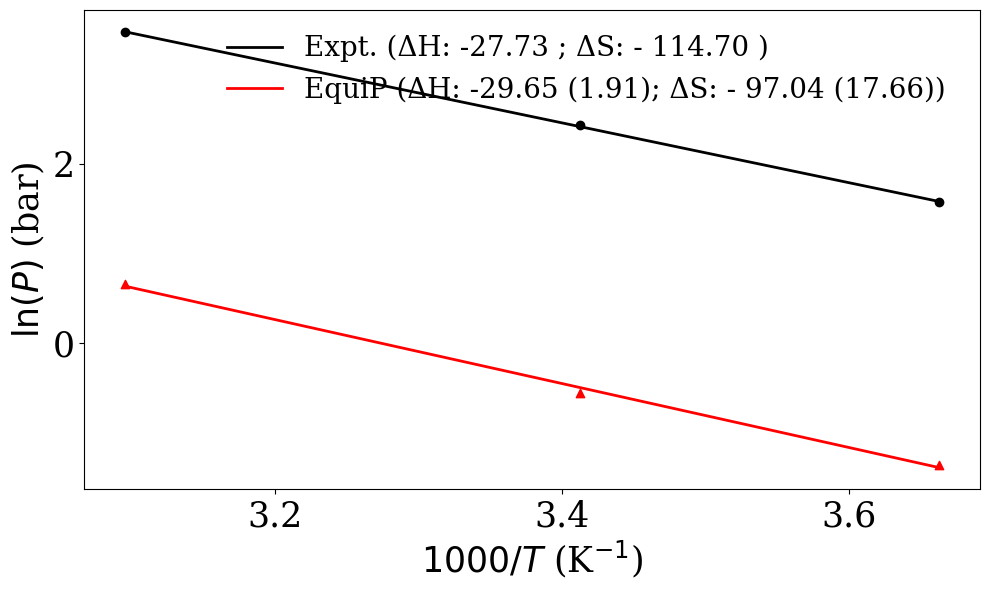

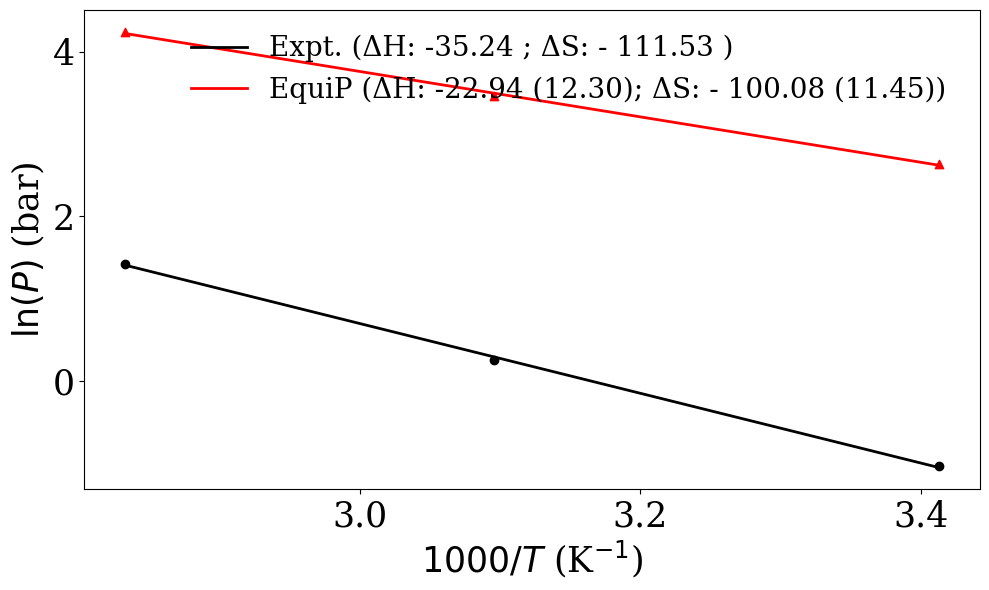

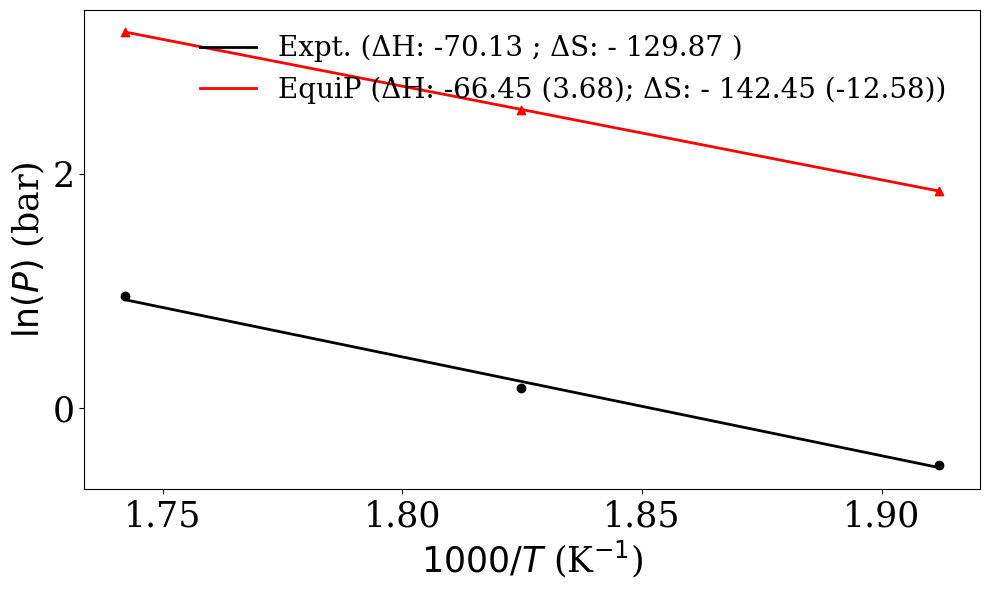

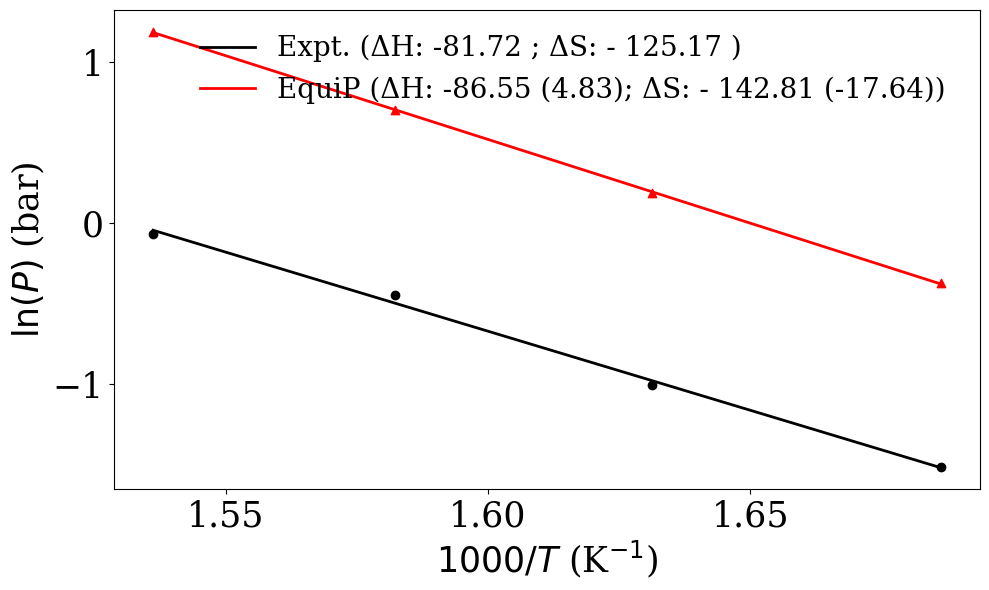

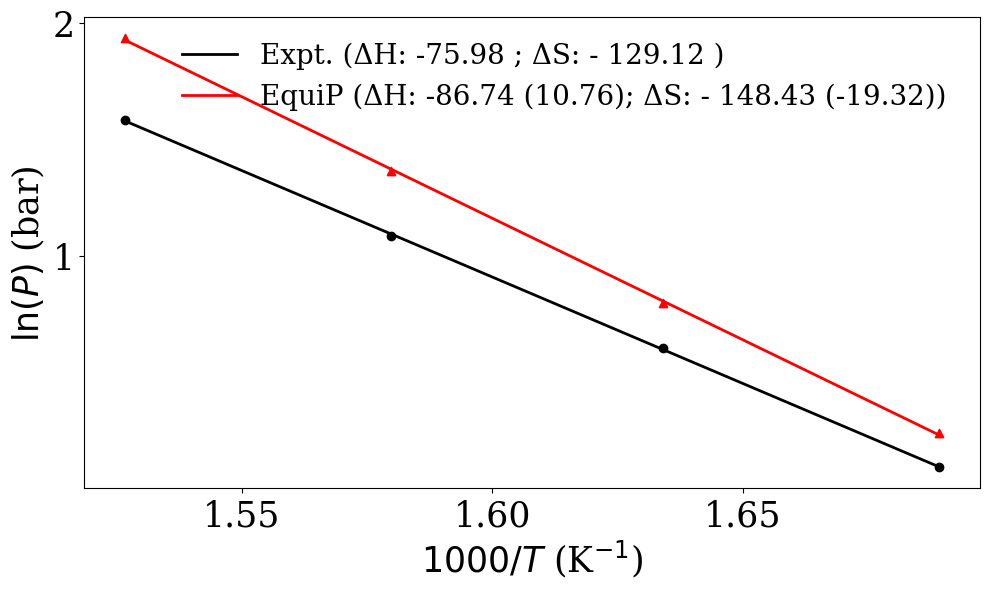

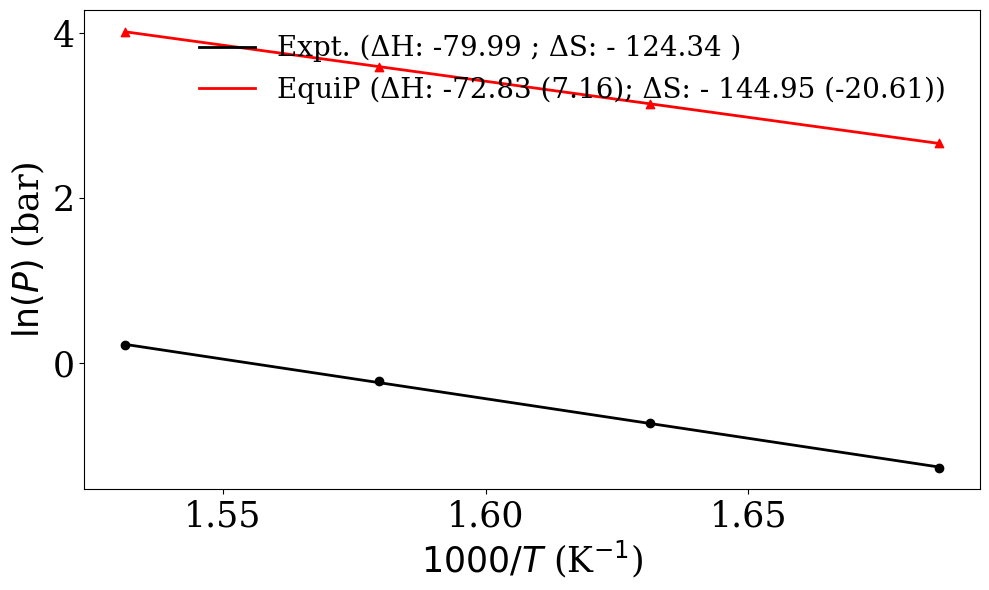

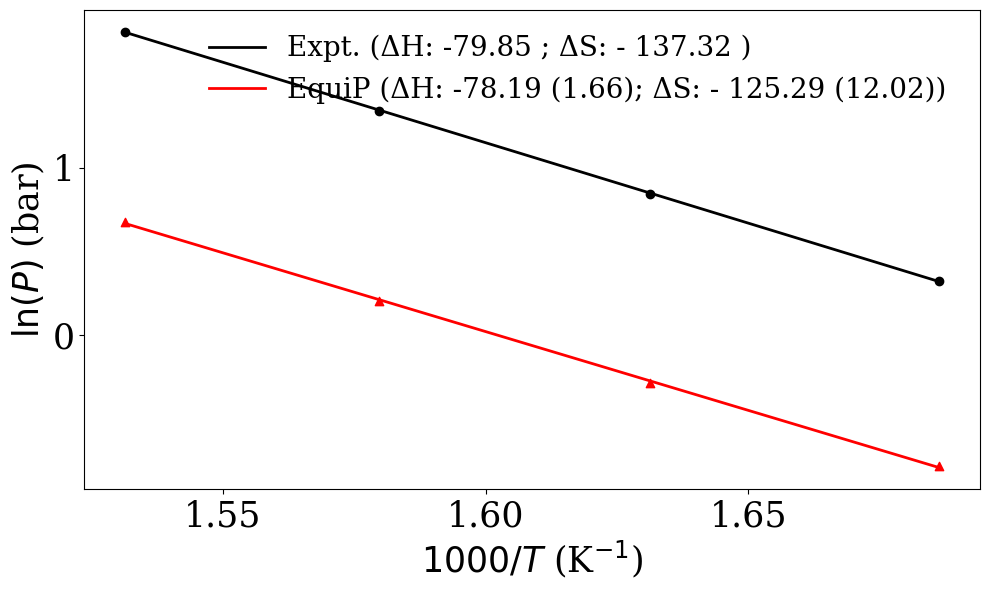

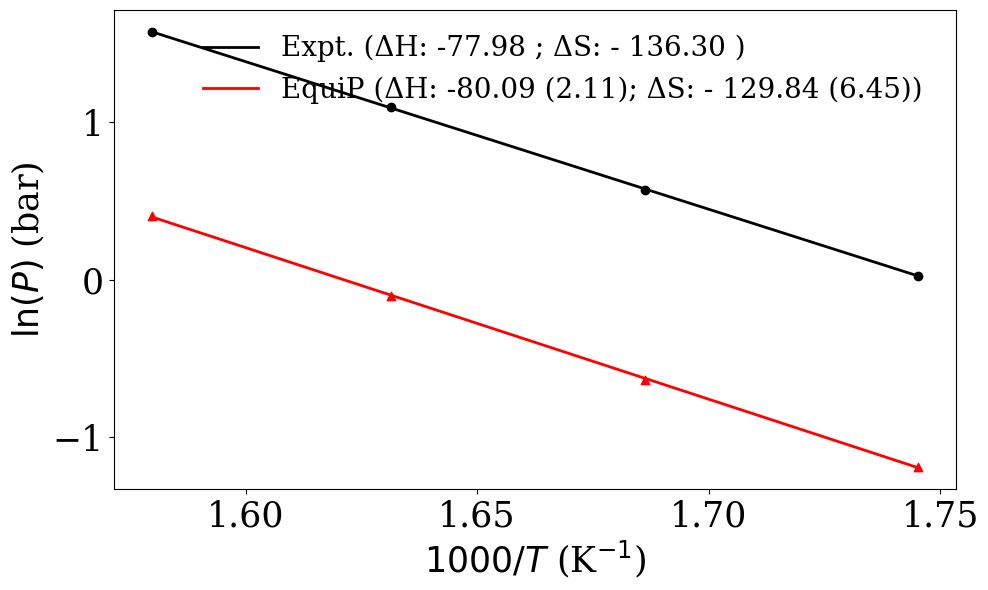

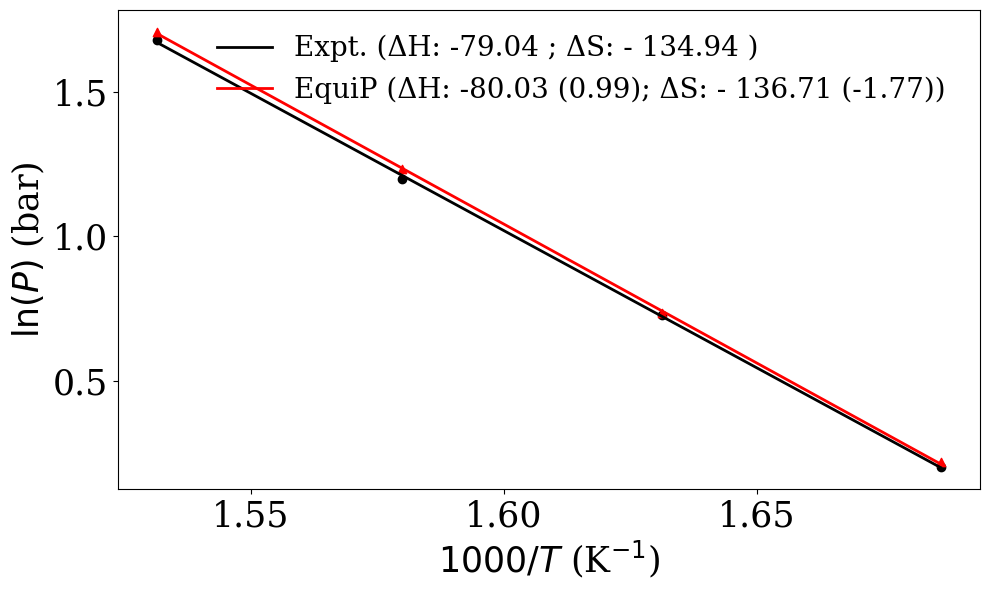

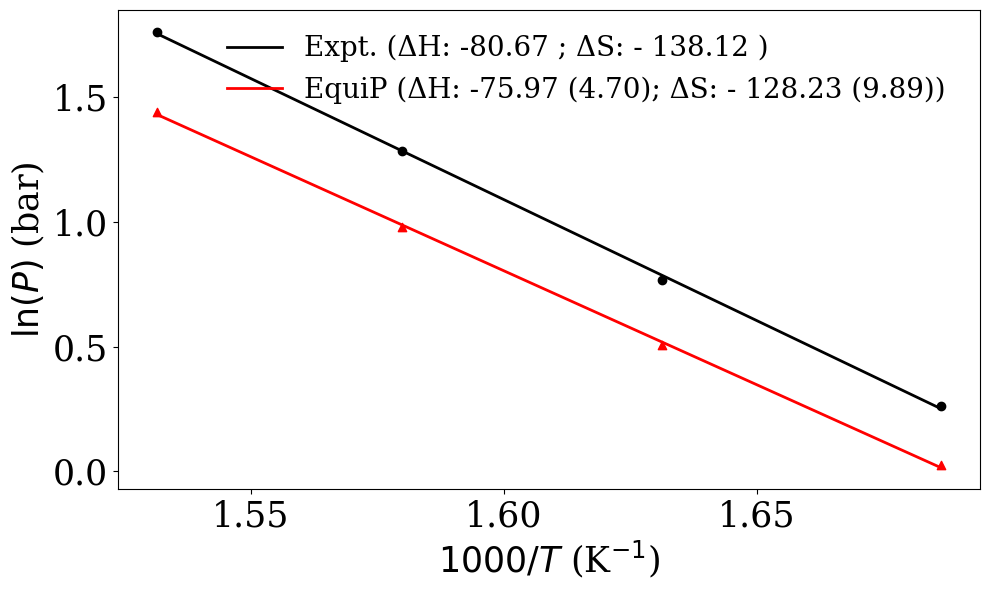

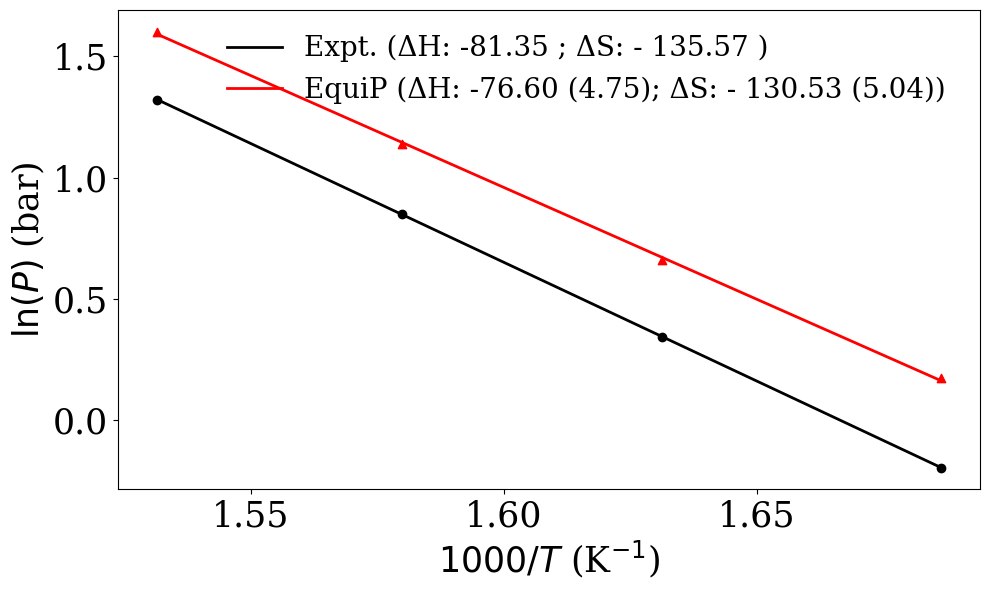

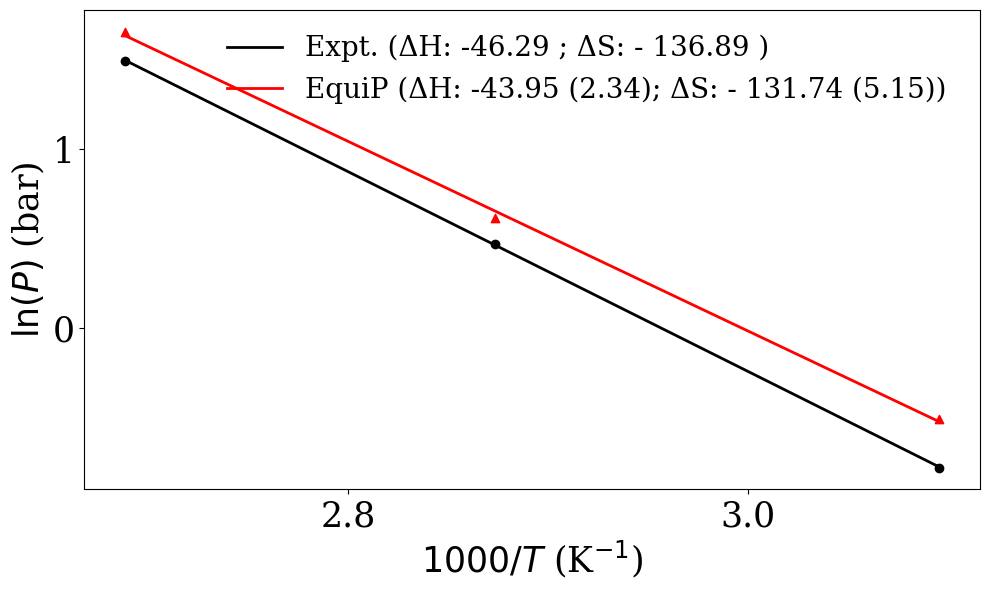

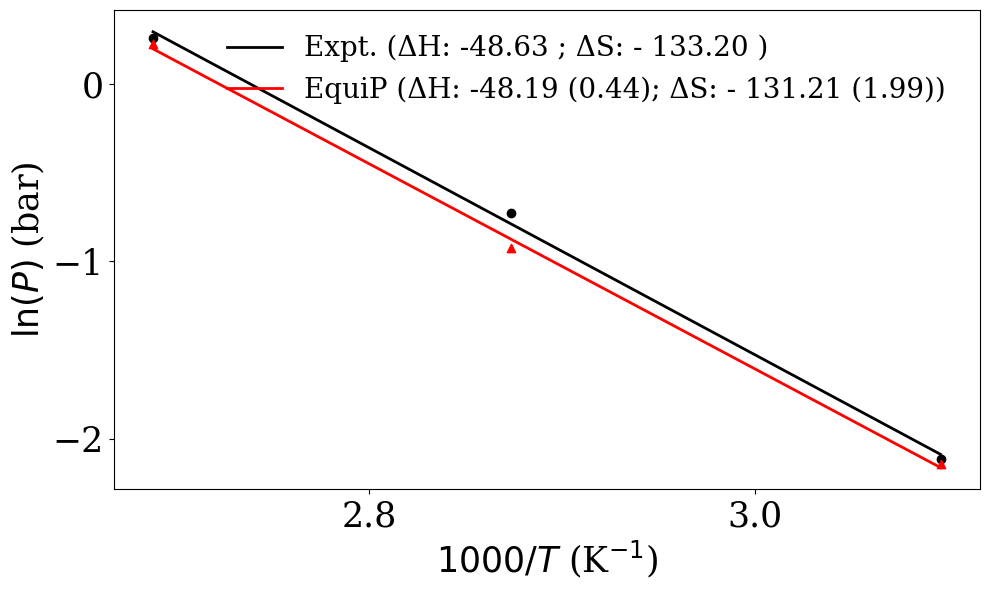

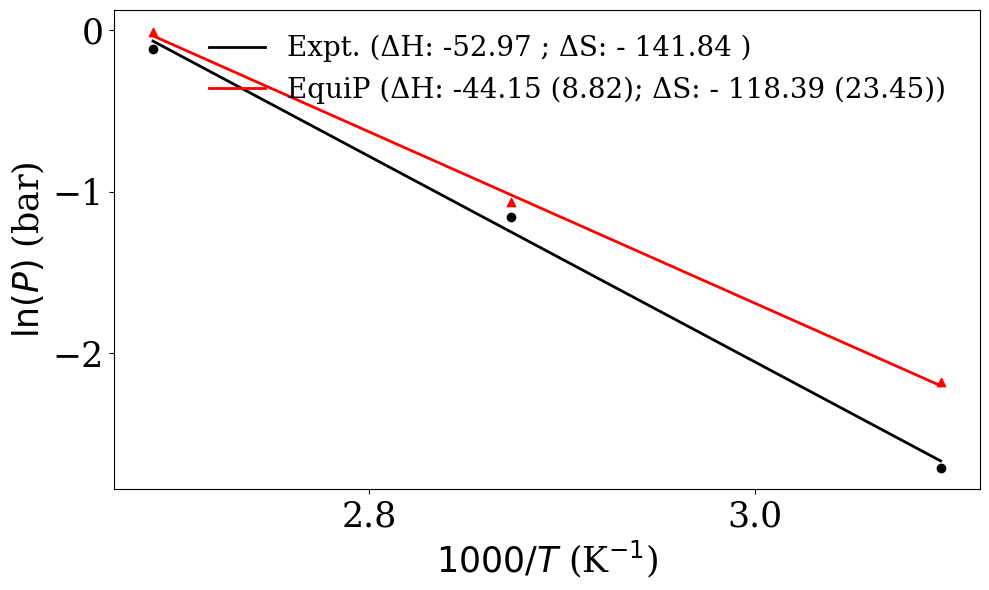

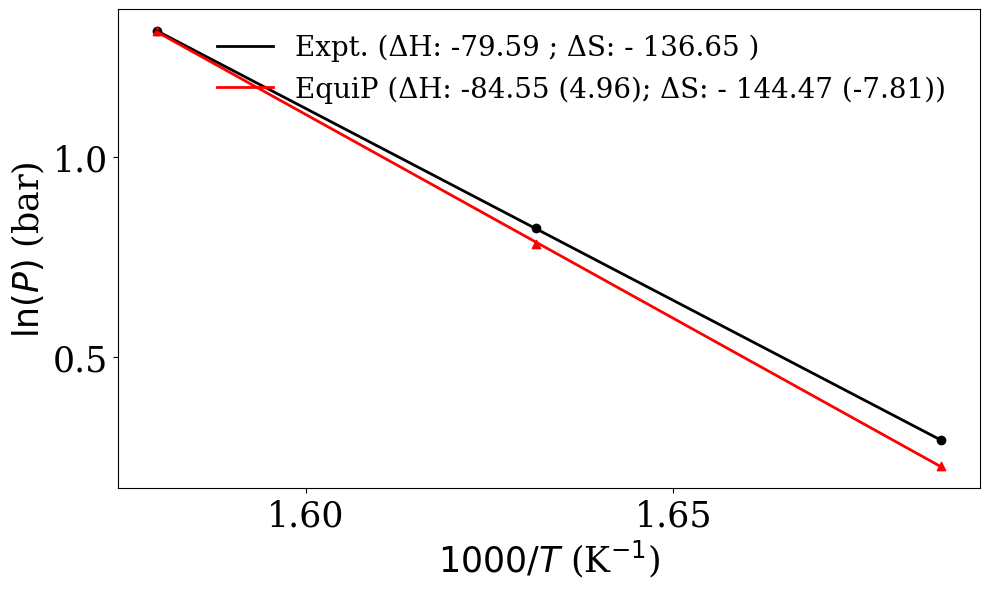

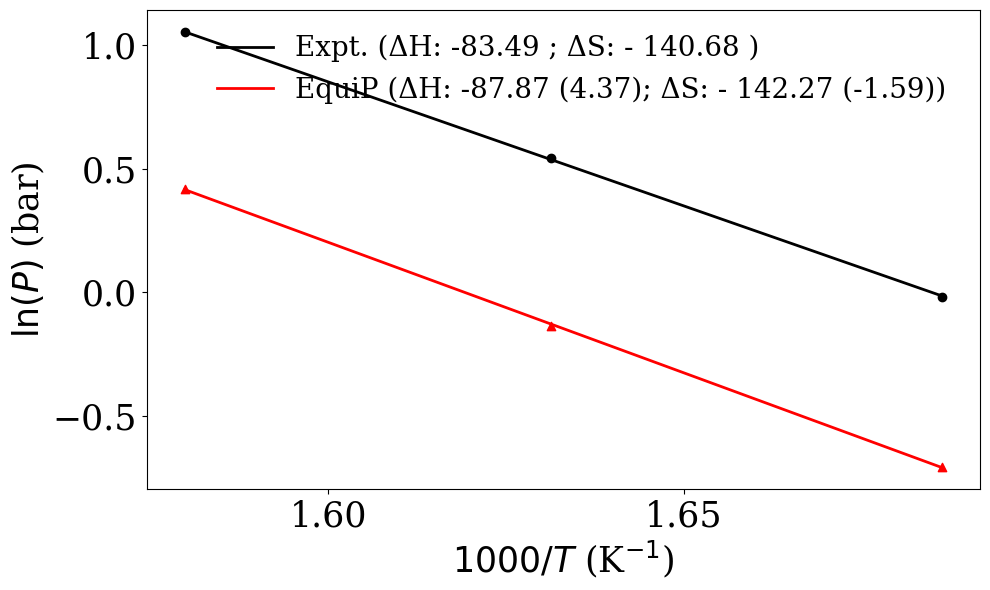

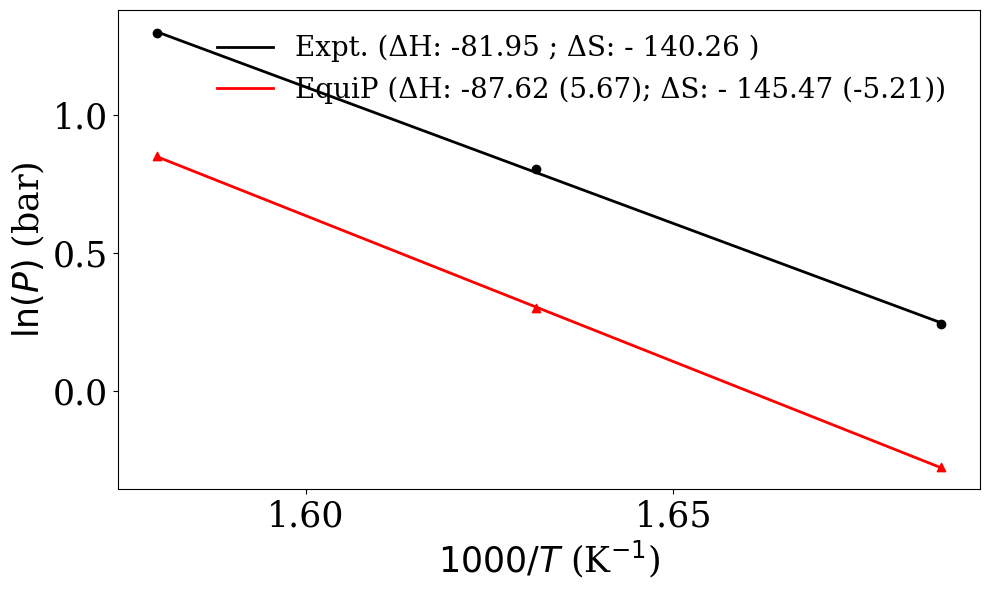

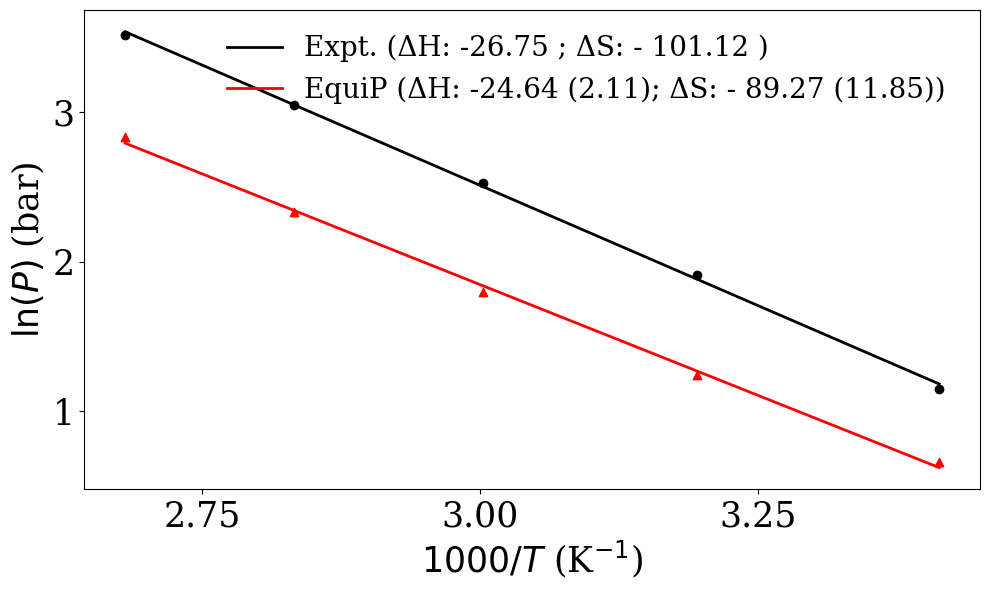

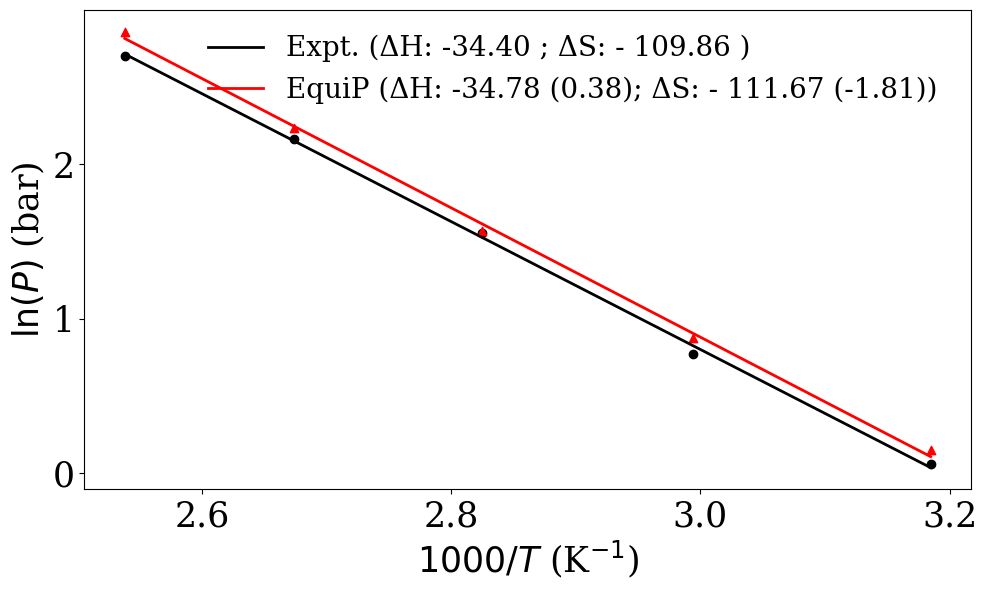

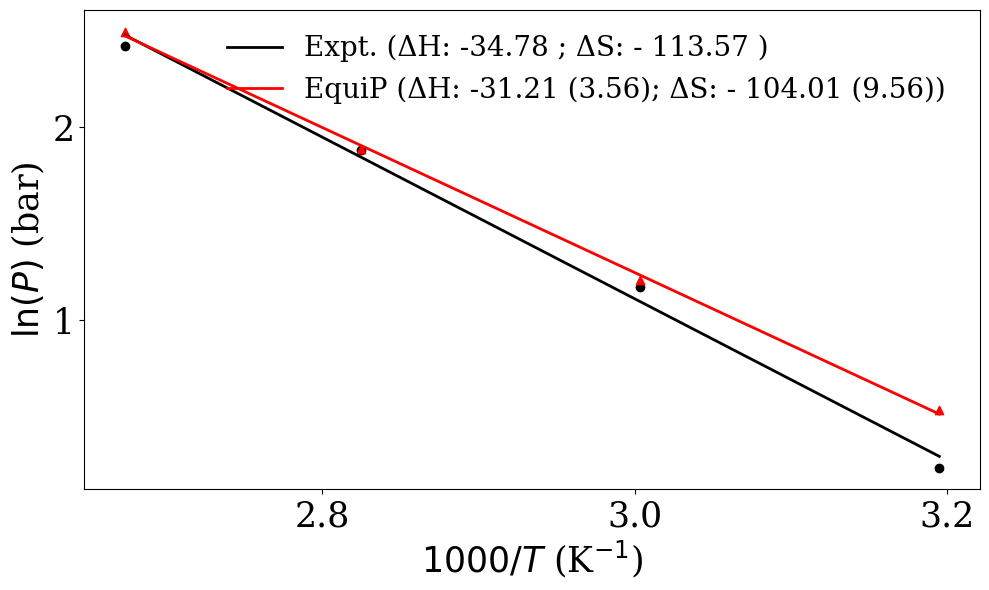

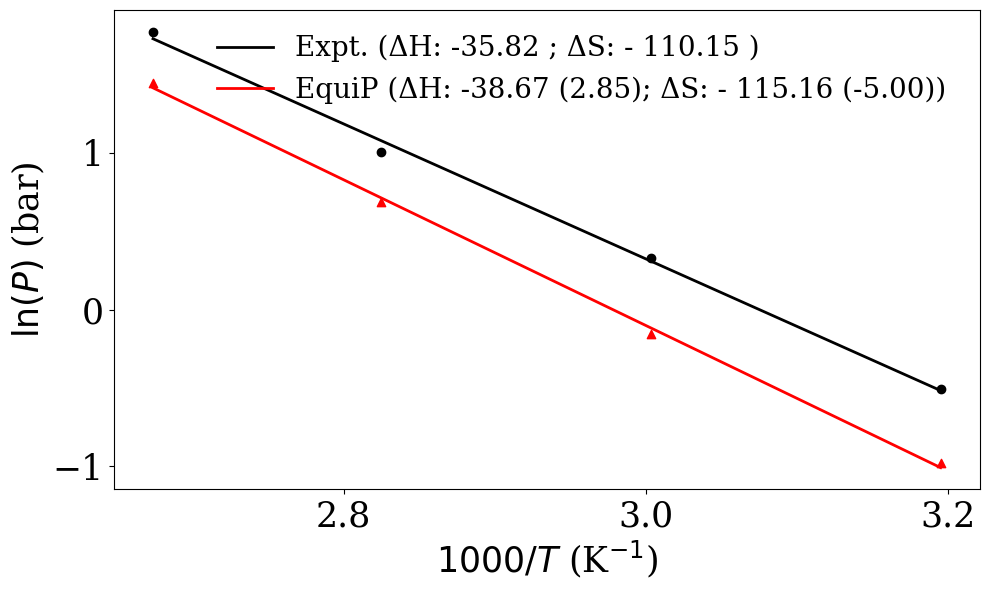

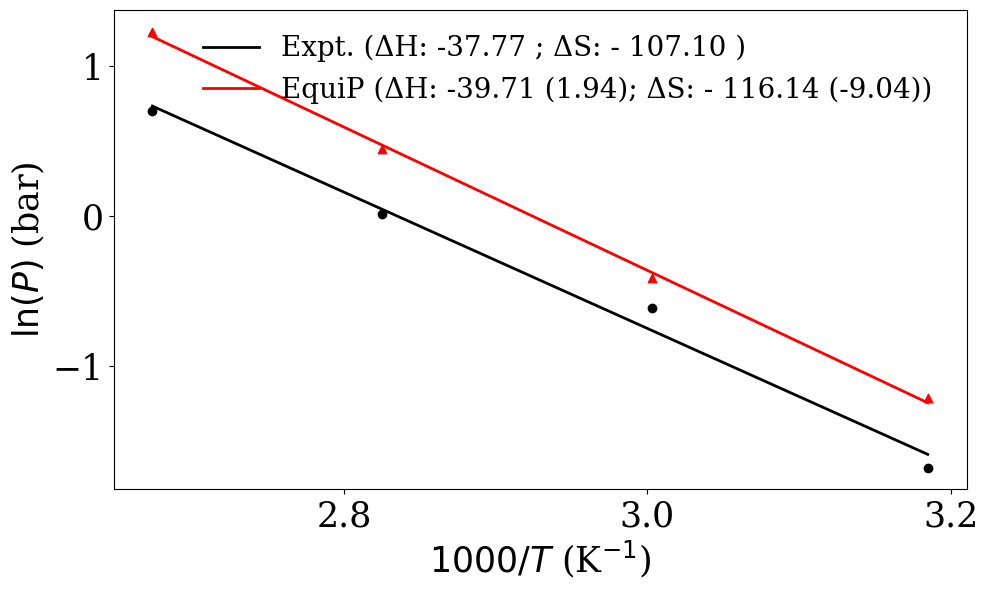

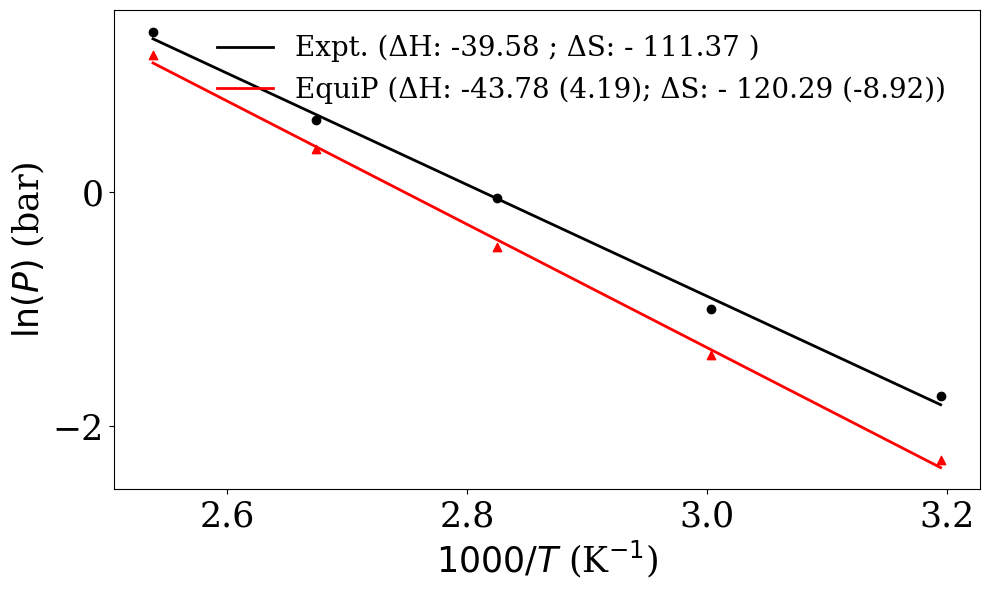

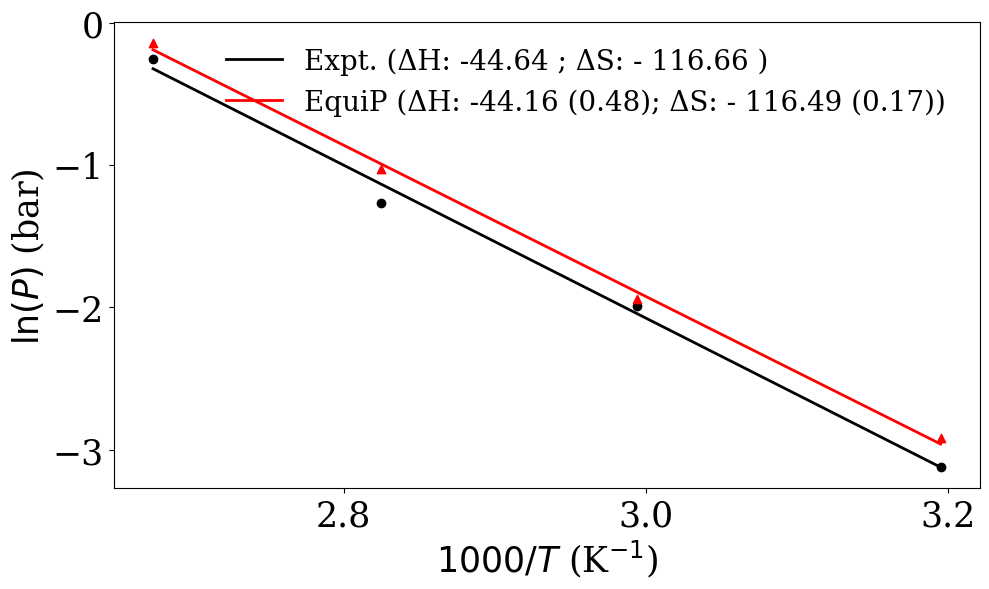

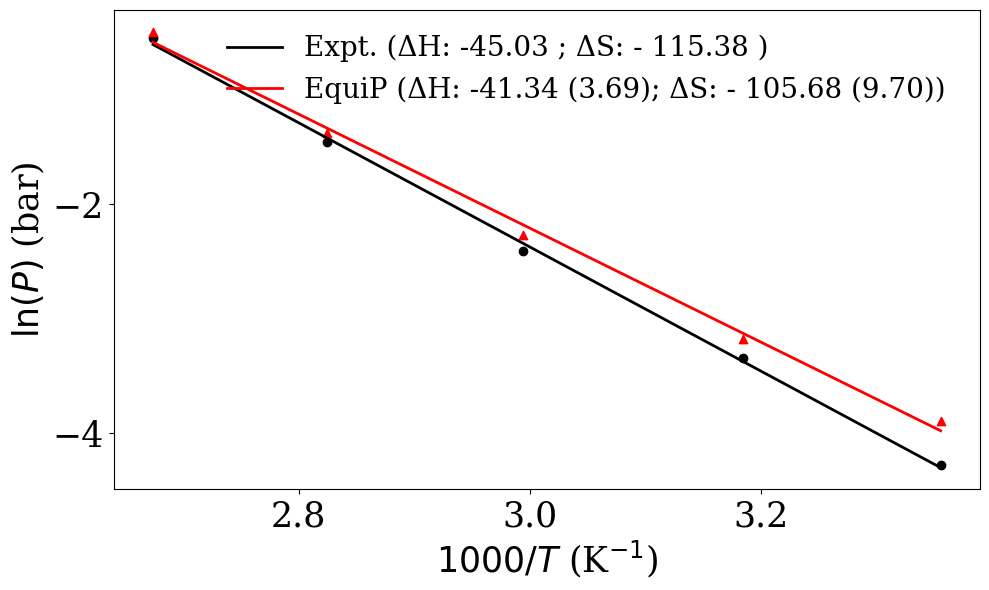

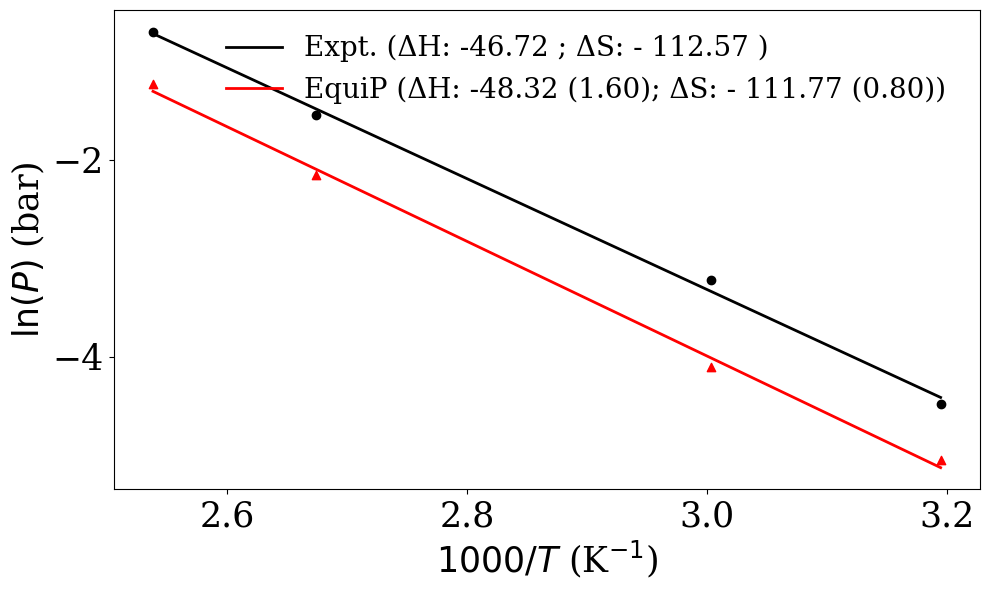

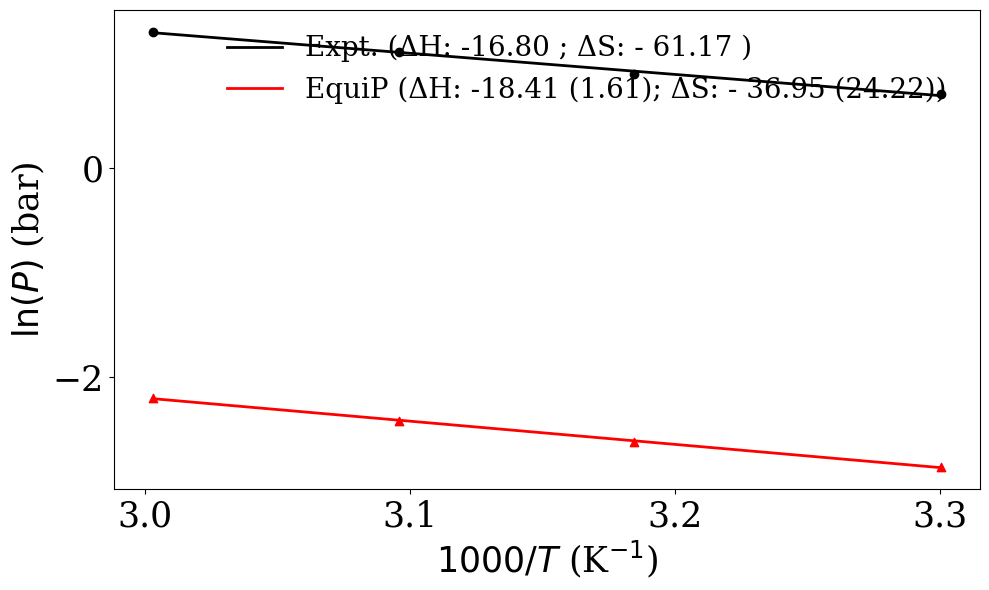

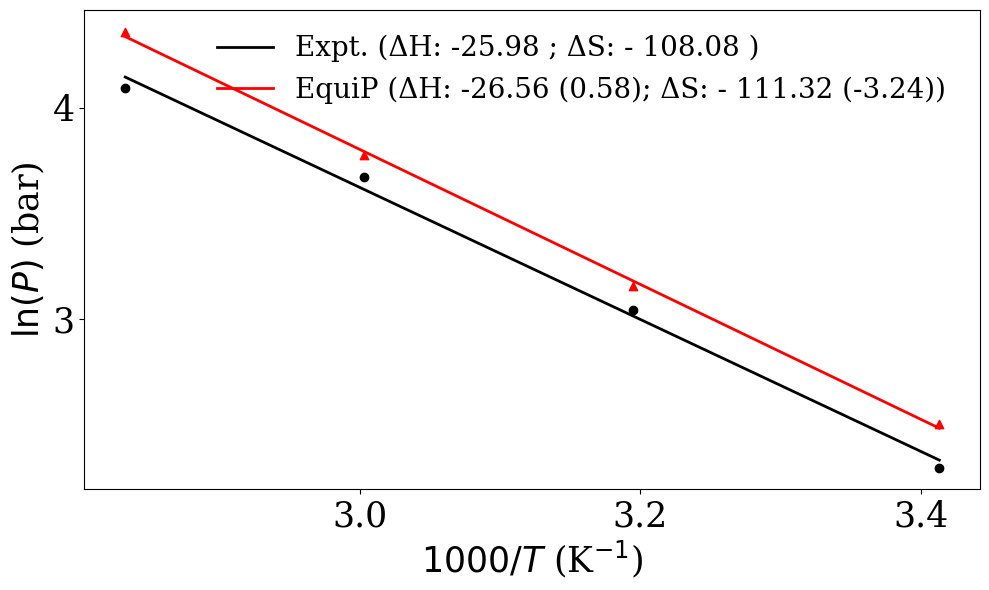

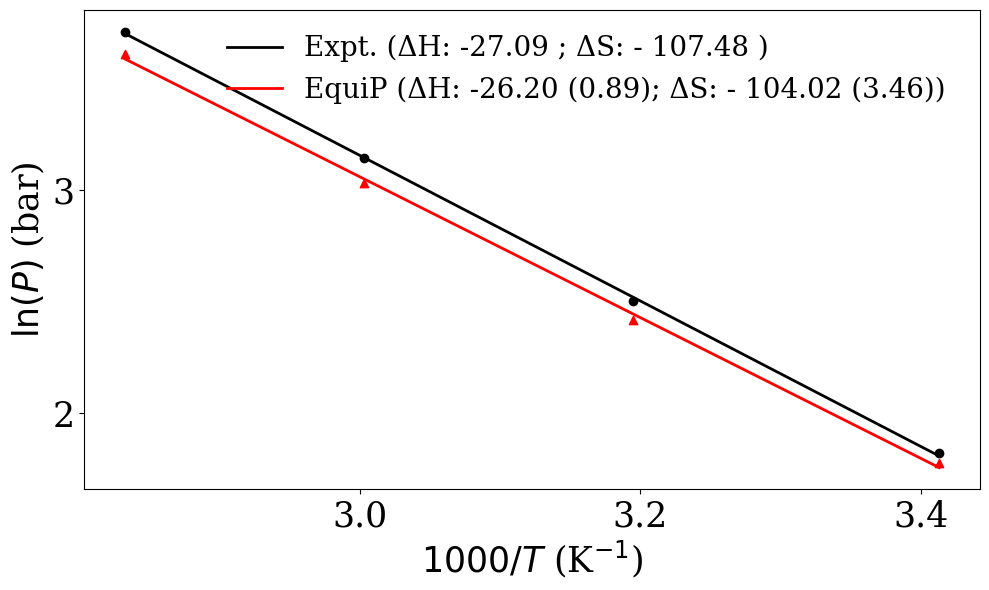

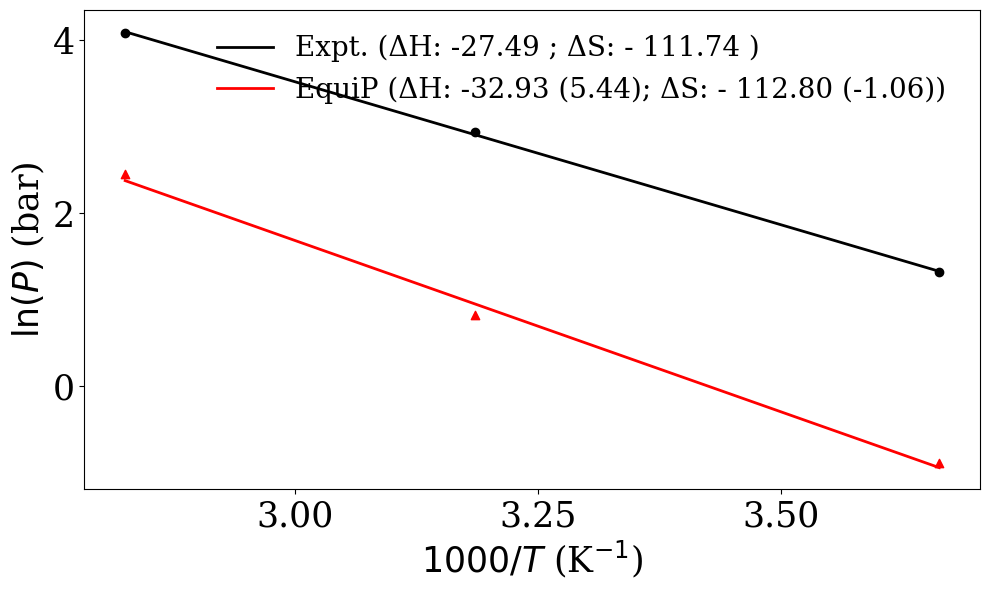

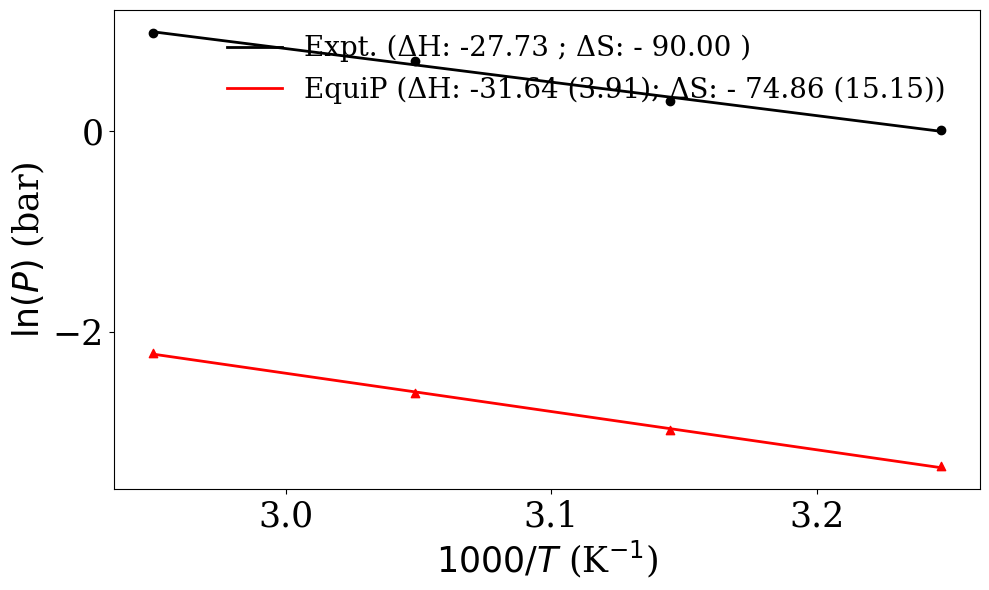

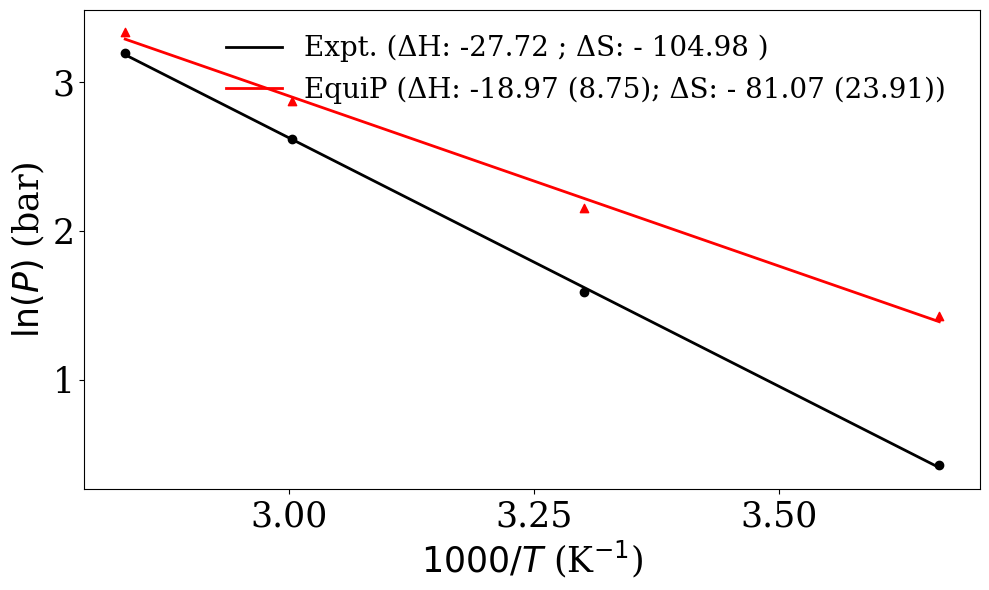

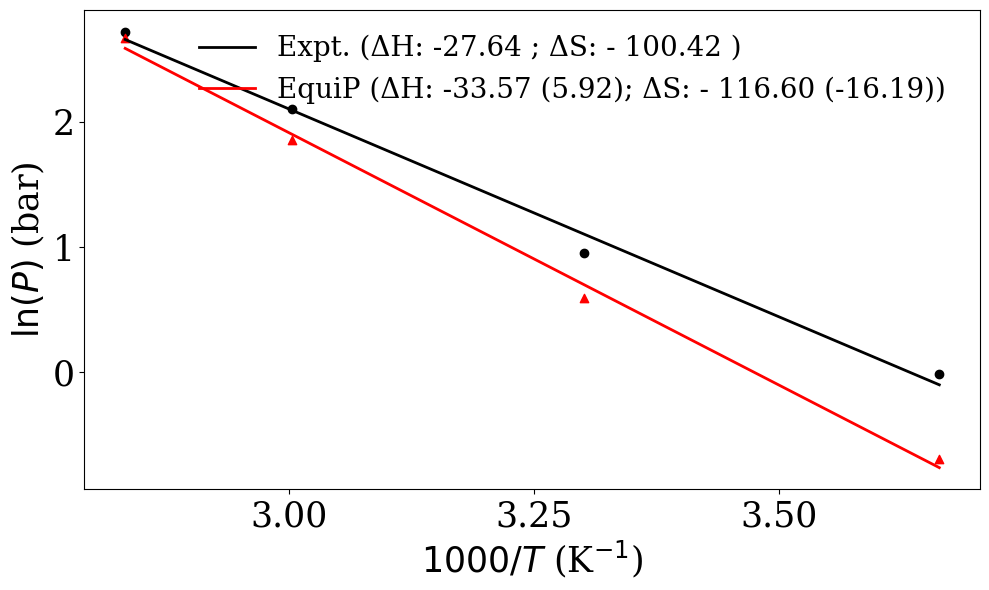

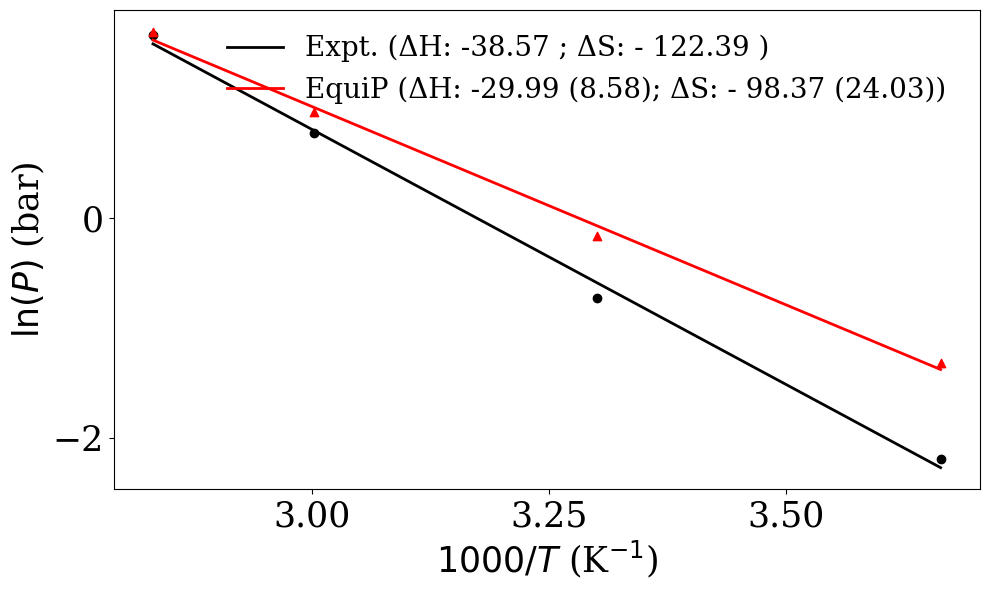

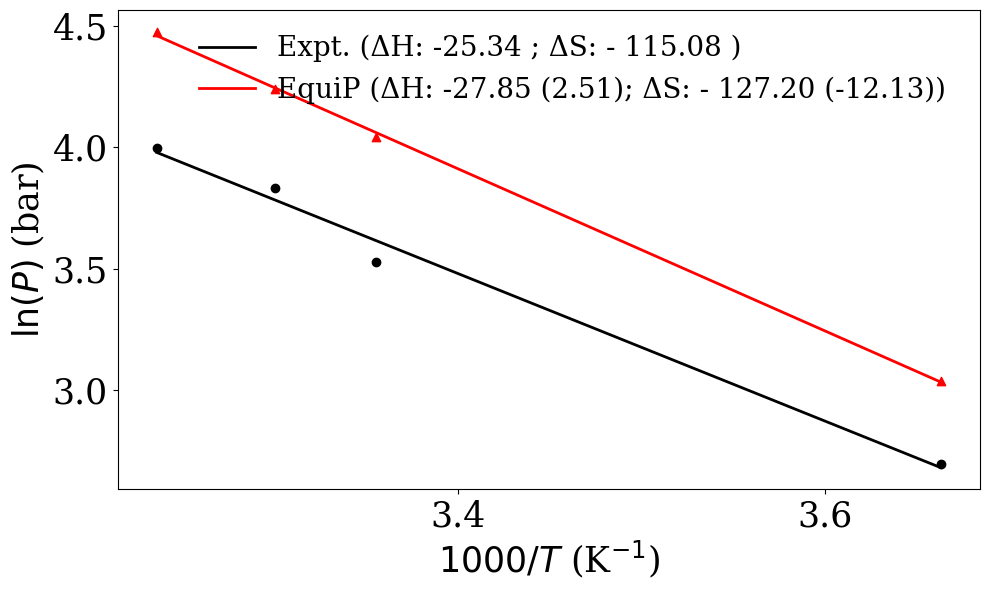

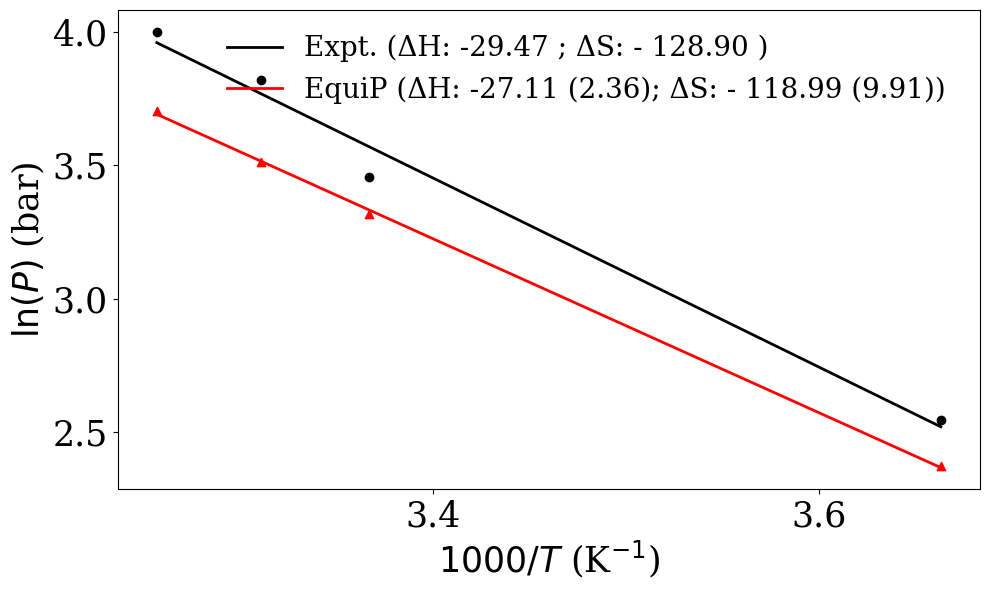

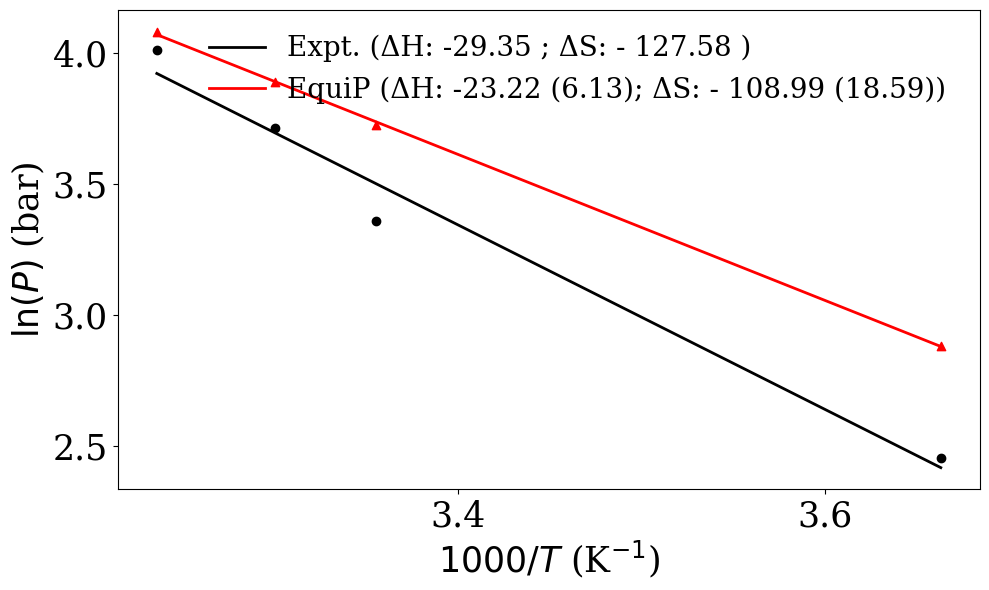

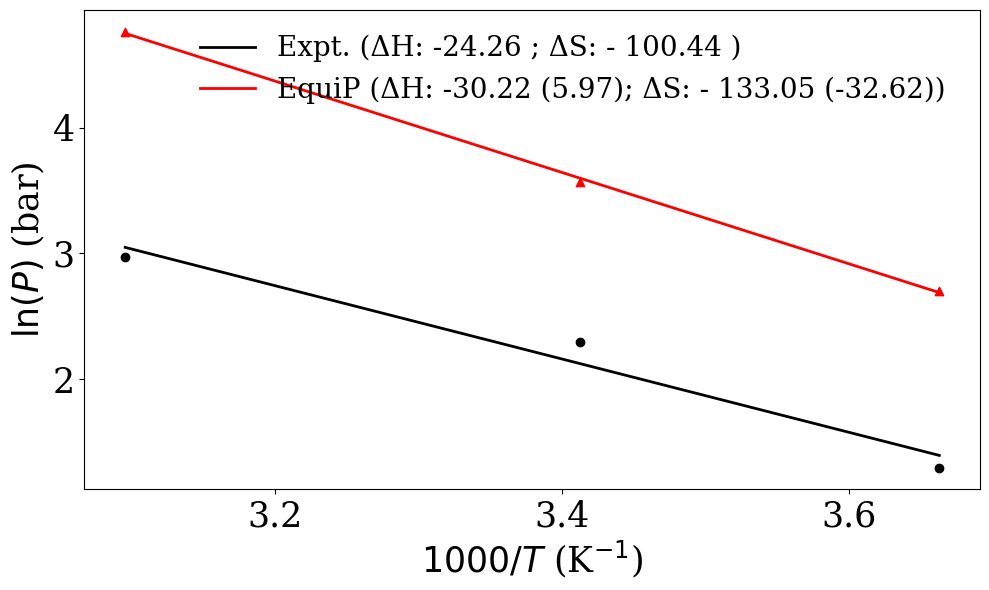

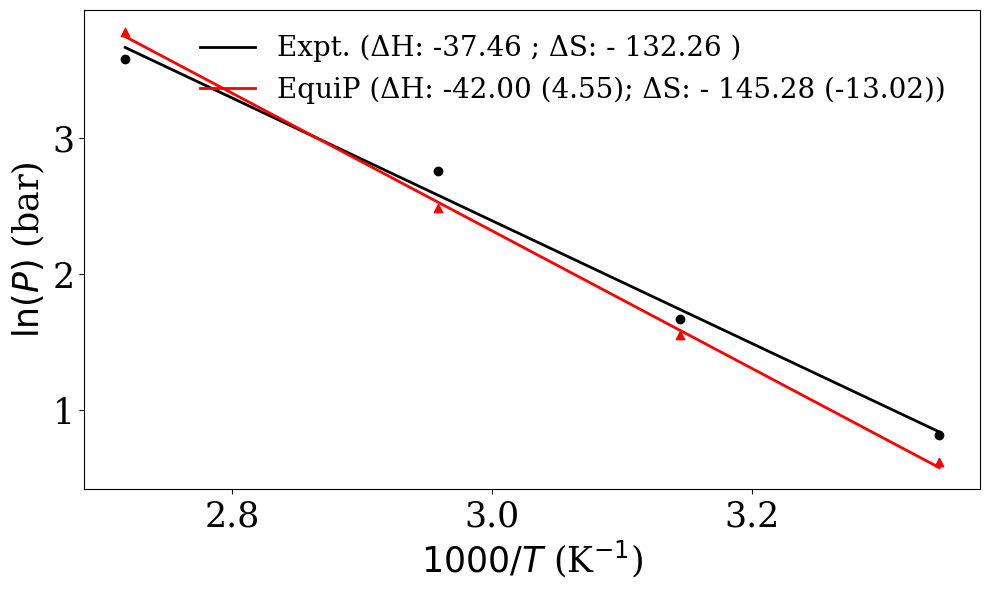

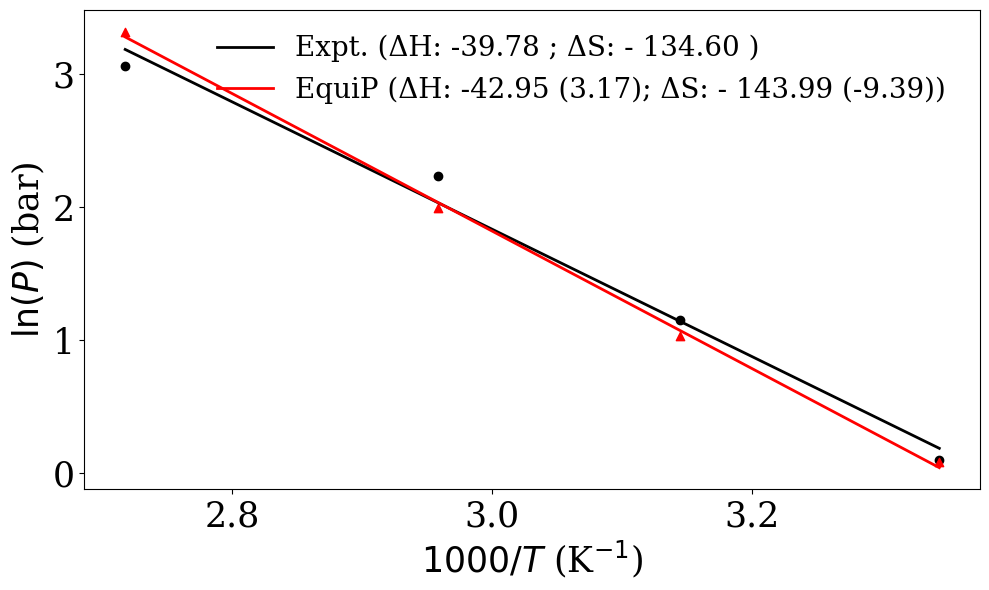

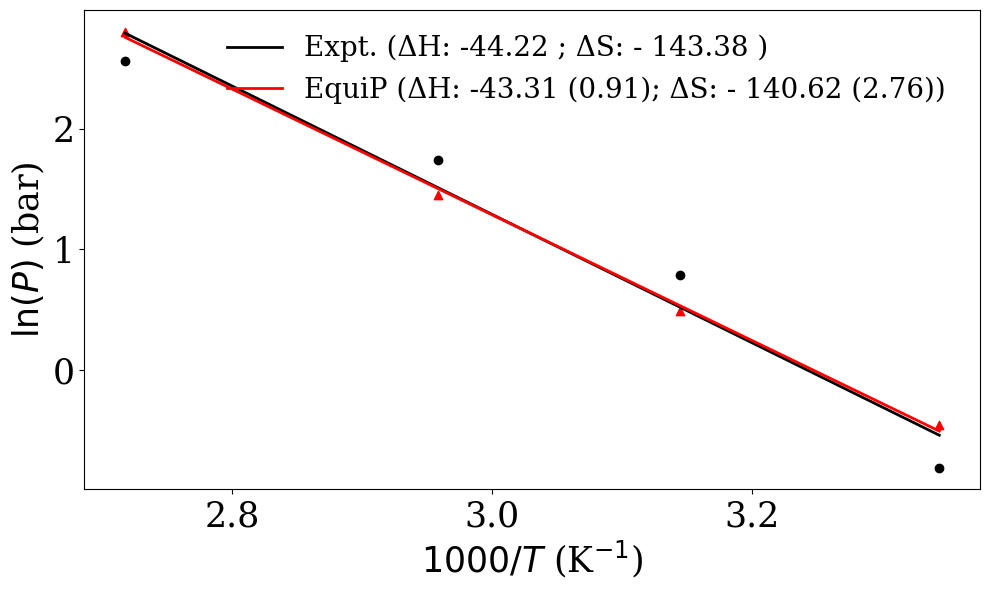

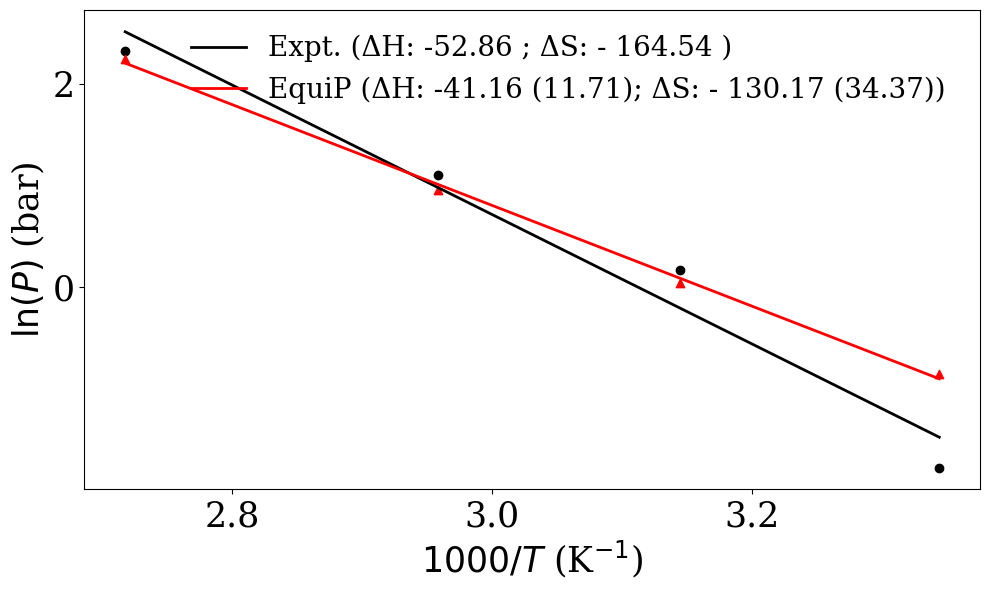

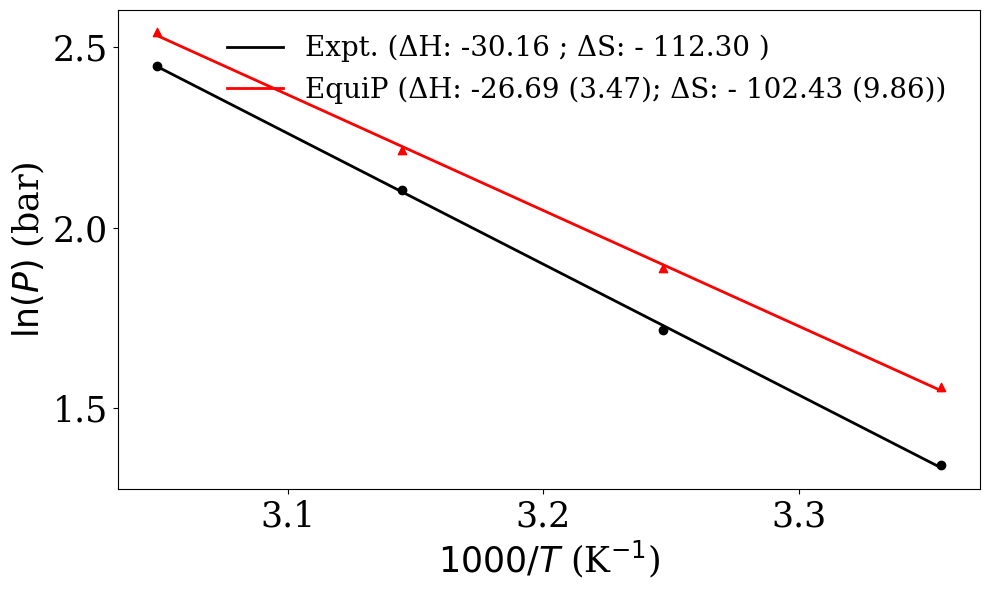

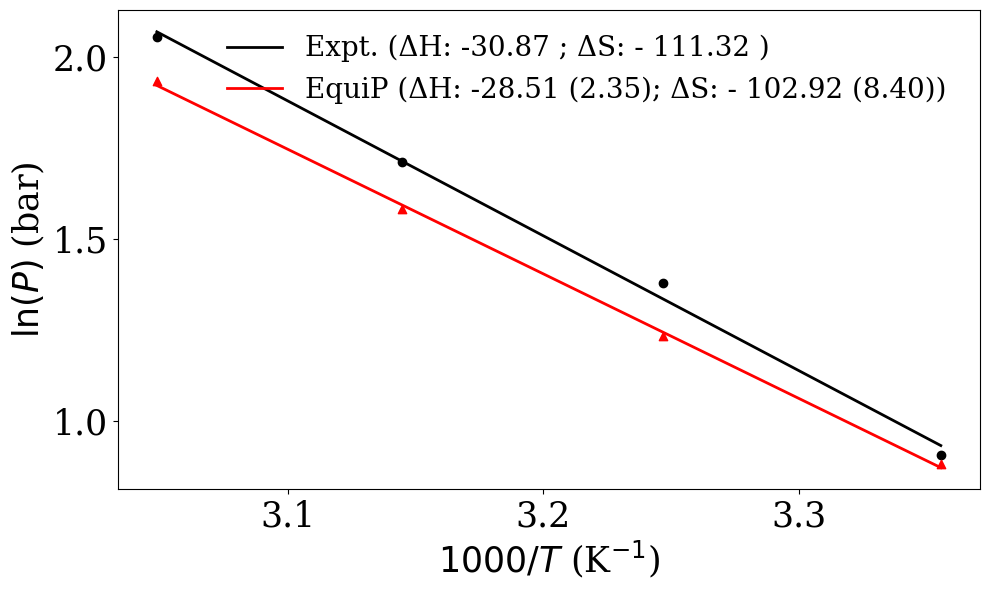

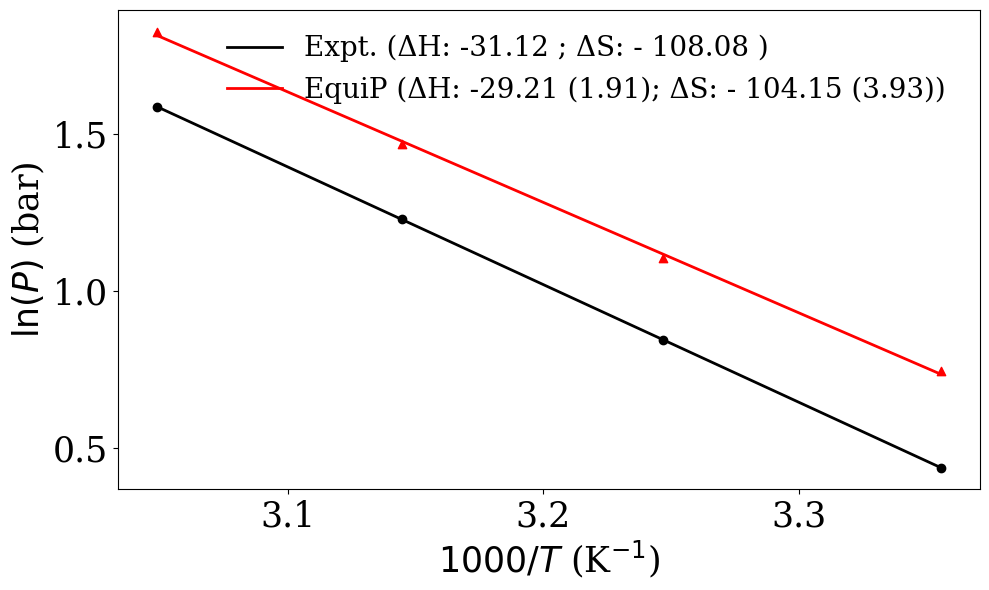

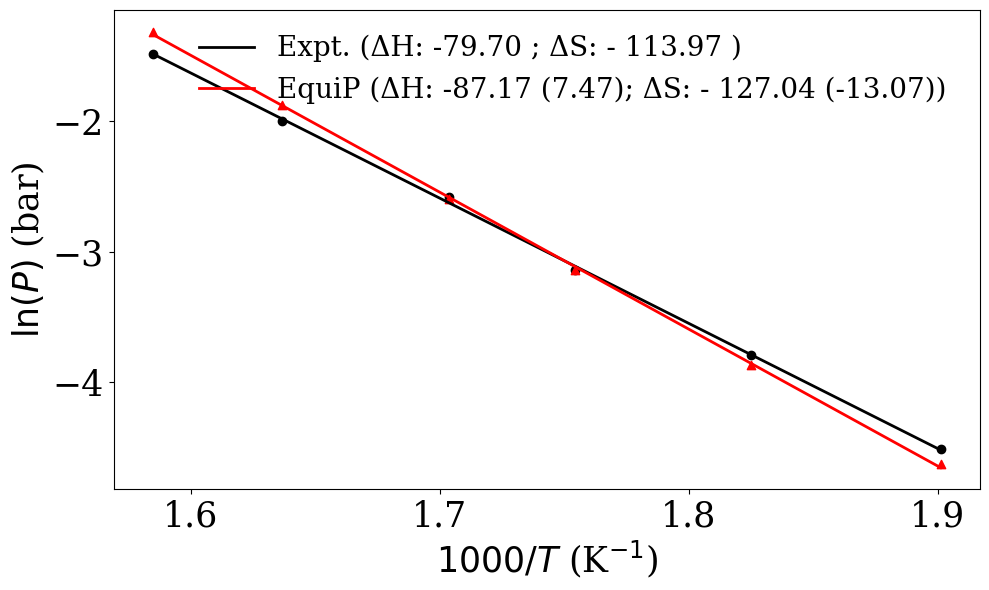

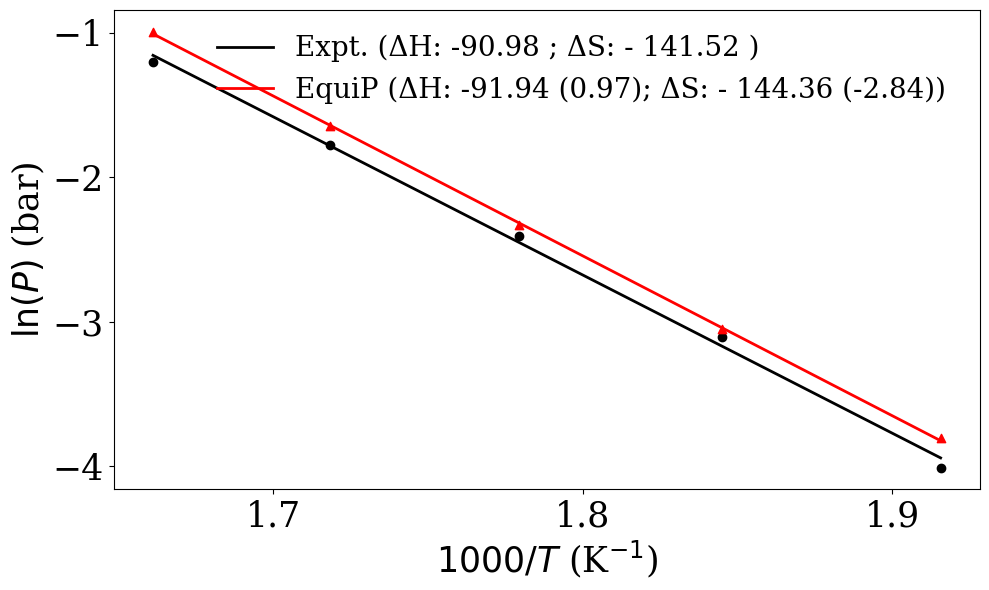

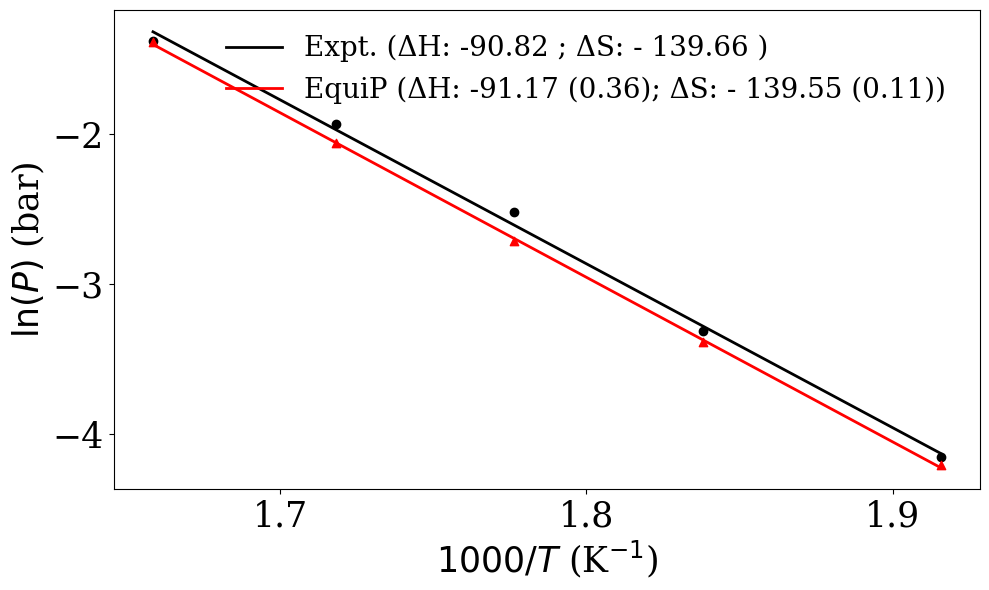

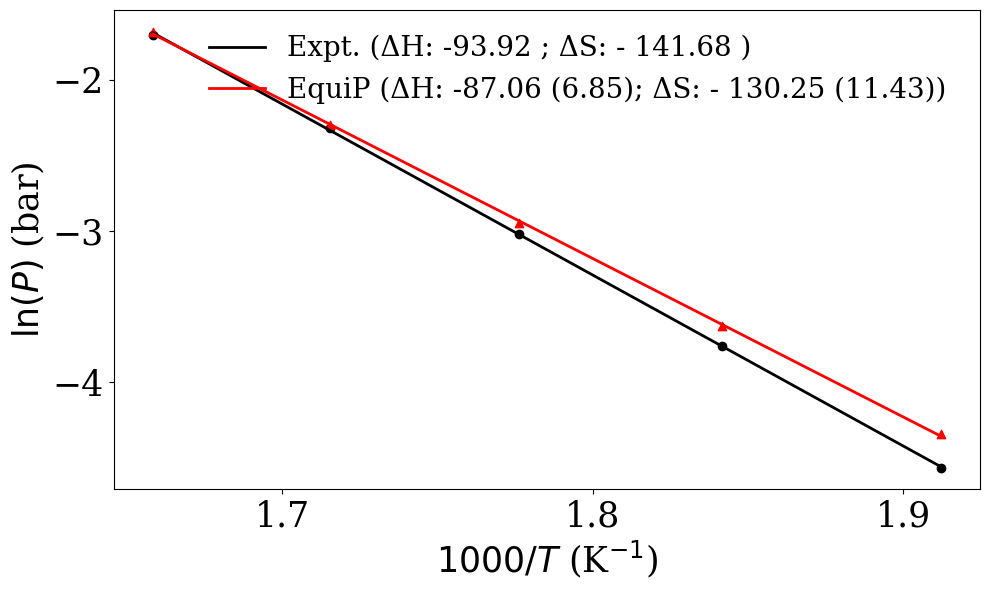

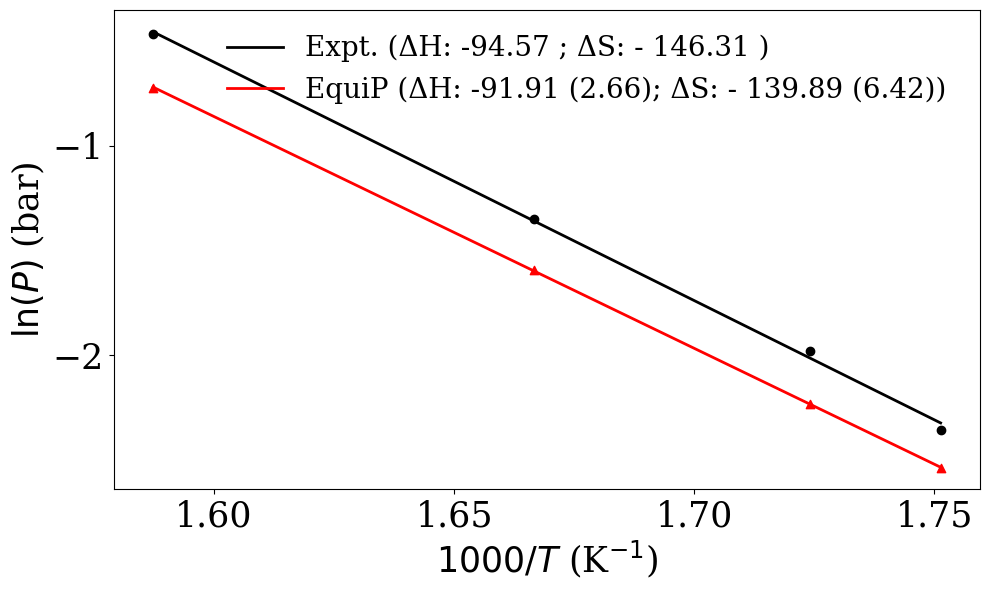

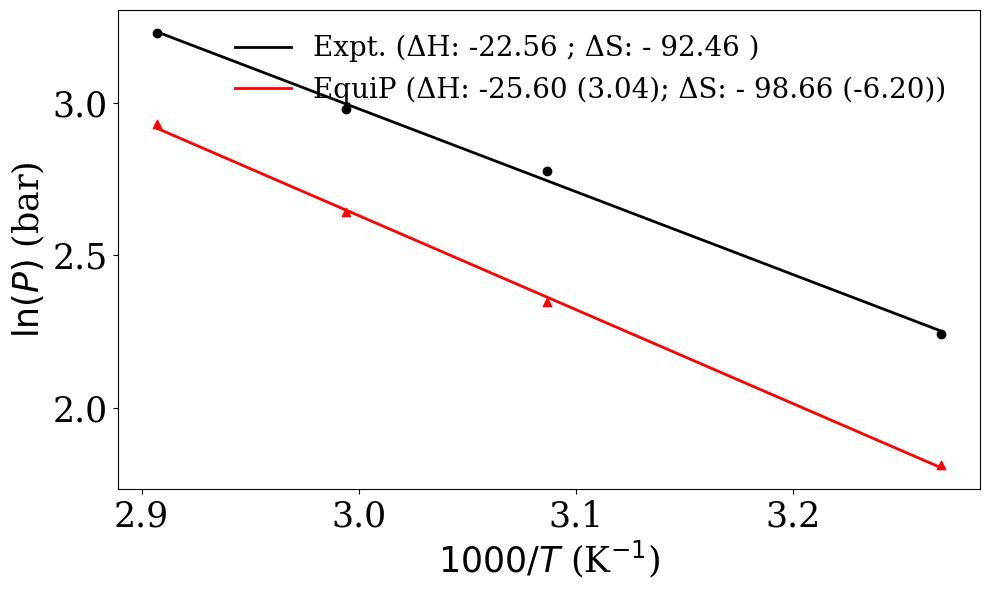

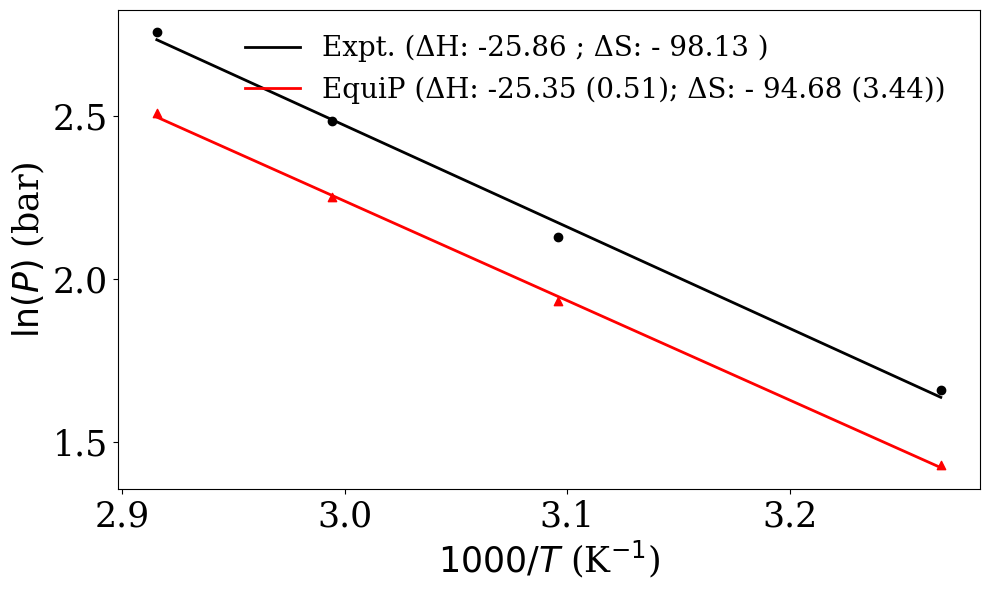

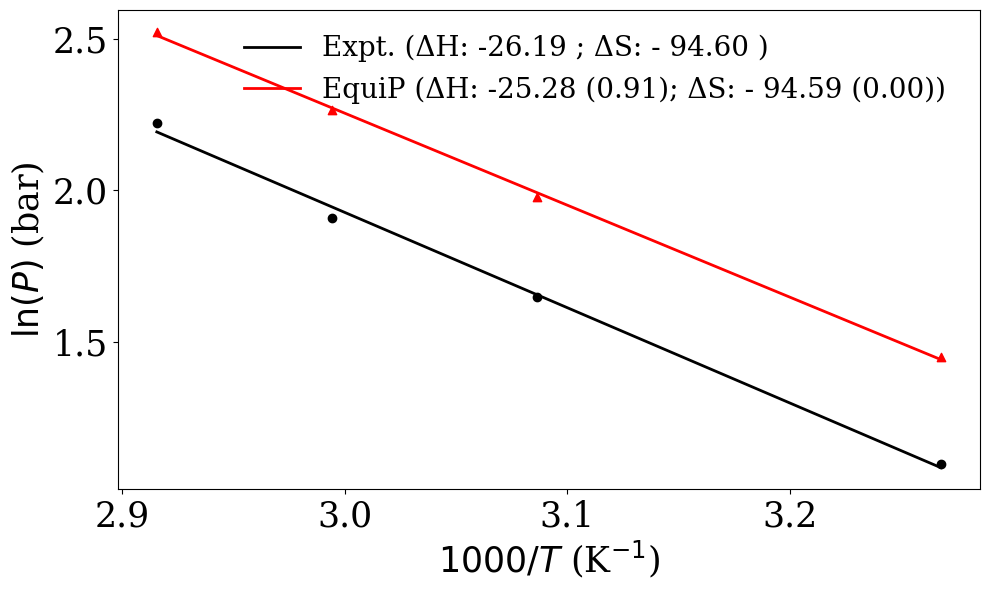

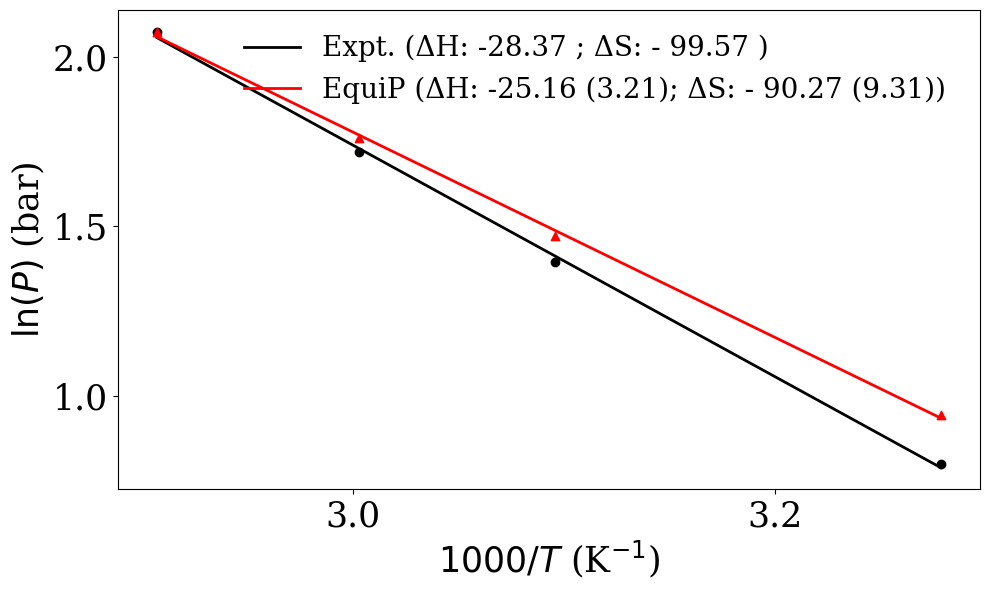

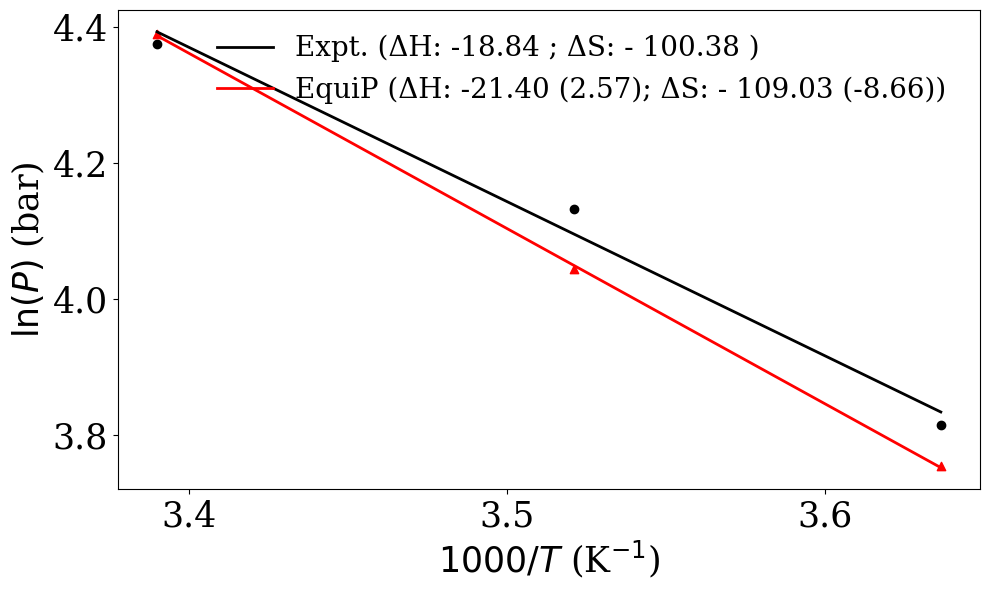

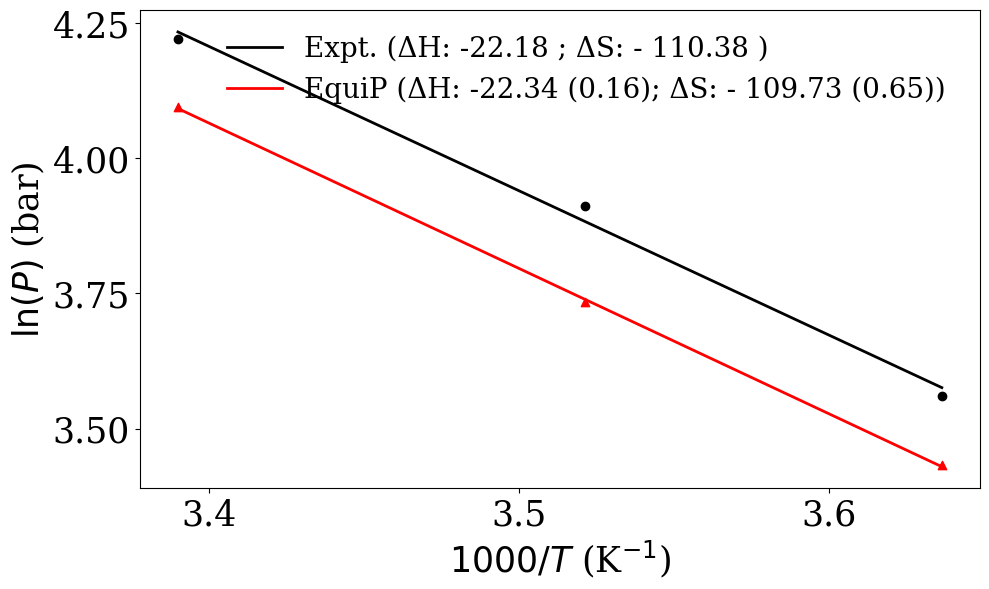

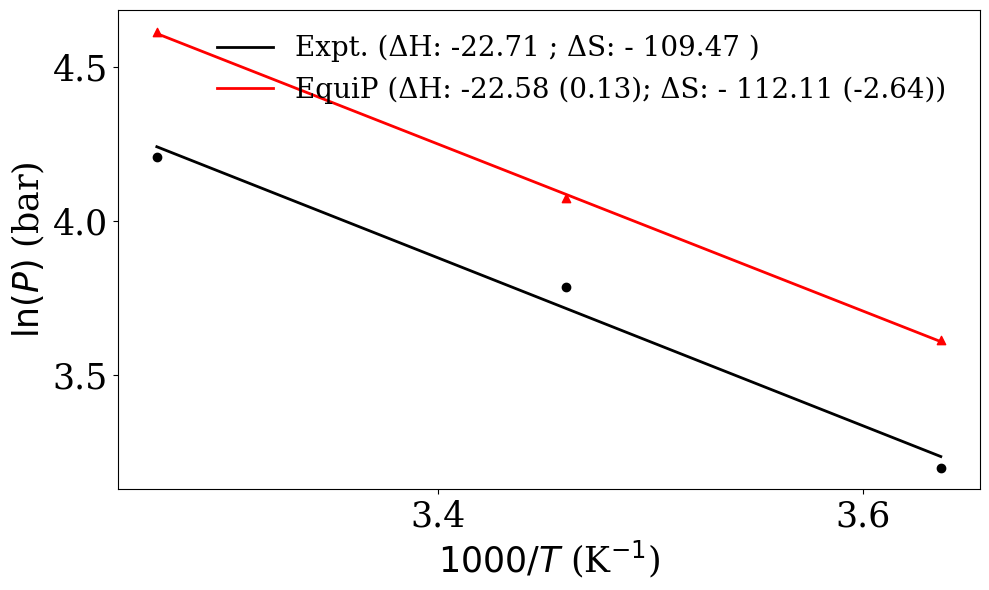

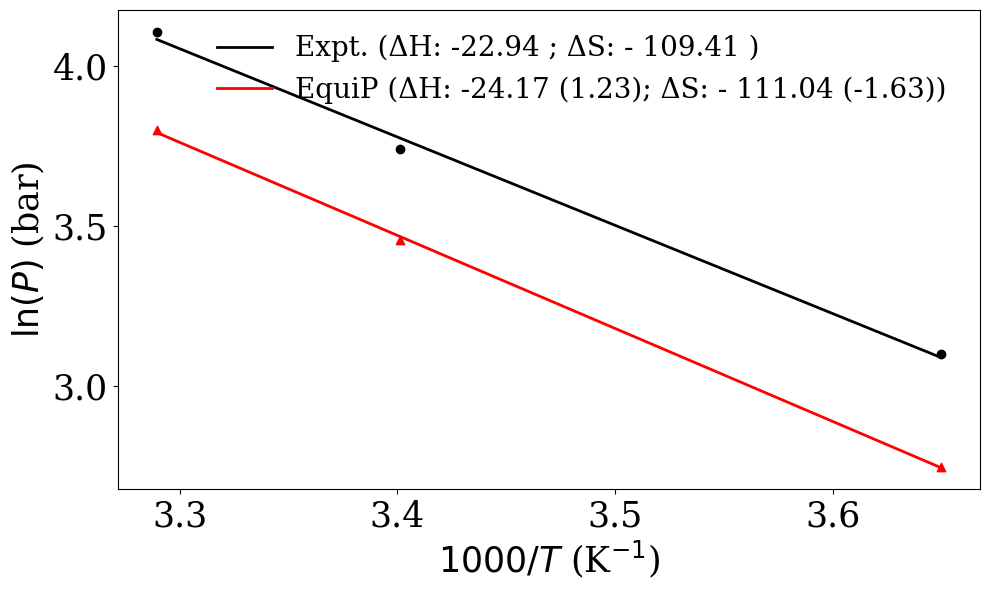

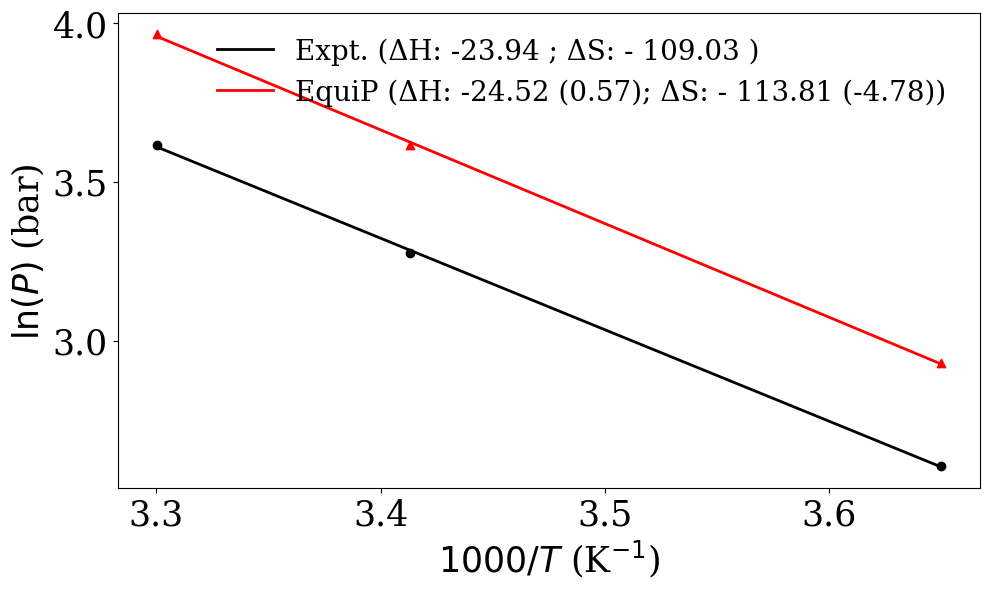

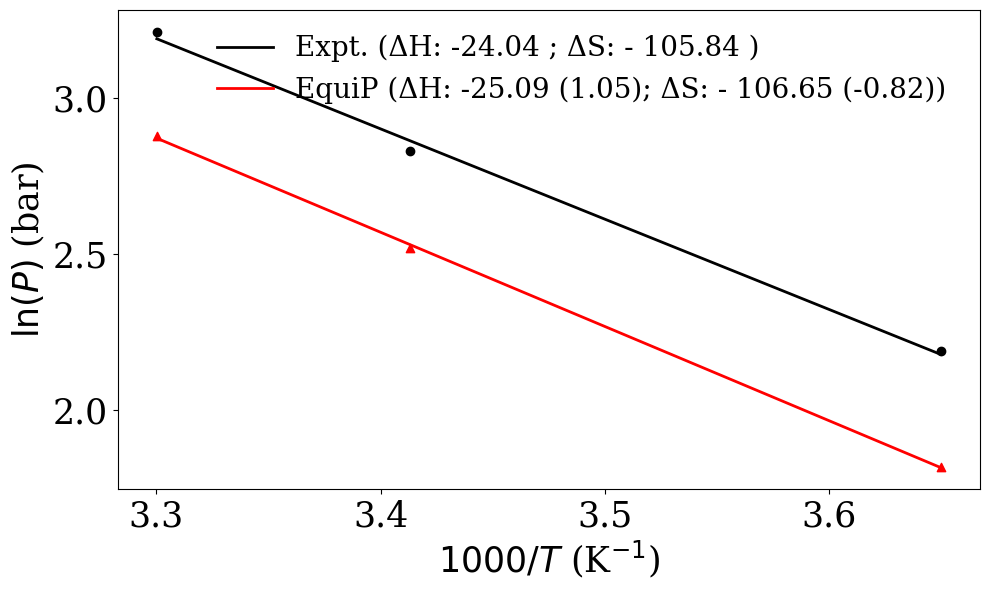

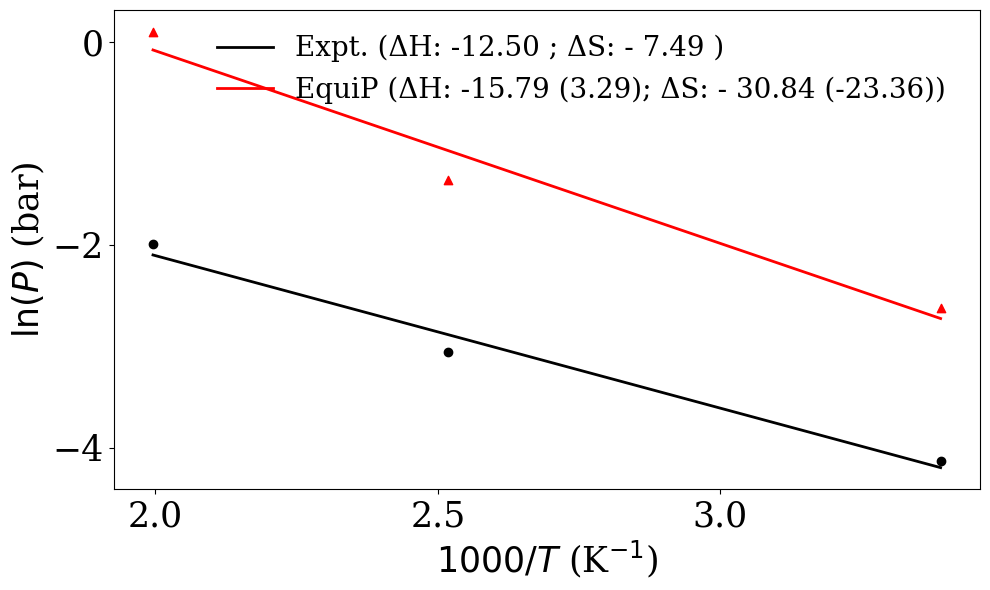

In [ ]:

from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

col1=['Temperature', 'CR',
       'FIE',  'BM', 'HF', 'MV',  'Mass',
    'M-H_Bond', 'M-H_Eng',    'formation_H',
       'vol_H',  'vol_diff', 'EN.Diff',
       'Atomic.Size.Diff', 'dSmix']
dff = []
unique_entries = data.drop_duplicates(['composition_final'])
test=data
Va = pd.DataFrame()

for xx in range(0,len(unique_entries)):
    q=unique_entries[xx:xx+1]
    compostion = q['composition_final']
    com=compostion.values[0]
    TEST=data[(data["composition_final"]==com)]
    TRAIN= data.drop(TEST.index)

    X_train1 = TRAIN[col1]
    y_train1 = TRAIN["Ln(P)_Mpa"]

    #Input and Target
    X_test1 = TEST[col1]
    y_test1 = TEST["Ln(P)_Mpa"]



    clf1=KernelRidge(kernel='rbf', alpha = 0.001, gamma = 0.1)
    clf1.fit(X_train1, y_train1)
    TEST['ML_KRR']=clf1.predict(X_test1)

    plt.figure(figsize=(10,6))
    plt.rcParams['font.family'] = 'Serif'
    plt.locator_params(nbins=4)
    plt.xticks(fontsize=25,)
    plt.yticks(fontsize=25)
    slope, intercept, _, _, _ = linregress(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['Ln(P)_Mpa'])))
    sl1= slope*8.314
    in1= intercept*8.314
    plt.scatter(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['Ln(P)_Mpa'])), marker='o',color='black')
    plt.plot((1000/(TEST['Temperature_1'])), slope*(1000/(TEST['Temperature_1'])) + intercept, 'ko-', linewidth=2, markersize=0, color='black', label=f'Expt. (ΔH: {sl1:.2f} ; ΔS: - {in1:.2f} )')
    TEST['Exp_Entalpy'] =sl1
    TEST['Exp_Entropy'] =in1
    slope1, intercept1, _, _, _ = linregress(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['ML_KRR'])))
    sl2= slope1*8.314
    in2= intercept1*8.314
    plt.scatter(1000/(TEST['Temperature_1']),np.log(10*np.exp(TEST['ML_KRR'])),marker='^',color='red')
    plt.plot(1000/(TEST['Temperature_1']), slope1*(1000/(TEST['Temperature_1'])) + intercept1, 'r^-', linewidth=2, markersize=0, label=f'EquiP (ΔH: {sl2:.2f} ({np.abs(np.abs(sl1)-np.abs(sl2)):.2f}); ΔS: - {in2:.2f} ({in1-in2:.2f})) ')
    TEST['ML_Entalpy'] =sl2
    TEST['ML_Entropy'] =in2
    plt.xlabel(r'$1000/T$ (K$^{-1}$)', fontsize=25)
    plt.ylabel(r'$\ln(P)$ (bar)', fontsize=25)
    plt.legend(loc="upper right",frameon=False,fontsize=20)
    plt.tight_layout()
    plt.show()


In [ ]:
import joblib
# Save model to file
joblib.dump(model, "krr_model.pkl")
print("Model saved as krr_model.pkl")

Model saved as krr_model.pkl


In [ ]:
# Load model
loaded_model = joblib.load("krr_model.pkl")

# Test the loaded model
y_pred = loaded_model.predict(X_test)
print("Experiment:", round(y_test.values[0],4))
print("Prediction:", round(y_pred[0],4))

Experiment: 0.3042
Prediction: 0.3851


# **Examples to train multiple ML architectures (Random Forest, CNN, RNN, LSTM, Transformer) for molecular property prediction using open-access datasets.**

In [ ]:
pip install rdkit torch torchvision torchaudio torchtext torch-geometric scikit-learn pandas numpy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.0 MB/s eta 0:00:00


In [ ]:
#Load & Preprocess Data (QM9 via PyTorch Geometric)
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
import torch